<b>Задание</b>
1. Познакомьтесь с данными.
2. Добавьте информацию из датасета region.csv.
3. Восстановите пропуски в столбце kitchen_area. 
4. Исследуйте рынок недвижимости в РФ за представленный период. Величина исследования - цена за м2. Обработайте аномалии.
5. Когда выгодно покупать/продавать объект недвижимости? 
6. Определите от каких признаков зависит стоимость объекта недвижимости. Найдите скрытые закономерности.
7. Выдвинете и проверьте собственную гипотезу статистическими методами.
8. Создайте модель прогноза цены объекта недвижимости.

Описание датасета realty_18_21.csv

date - дата объявления

region - Регион

building_type - Тип дома 0 - Другое. 1 - Панельный. 2 - Кирпично-монолитный. 3 - Кирпичный. 4 - Блочный 5 - Деревянный

object_type -  1 - Вторичный рынок; 11 - Первичный рынок;

level - Этаж

levels - Число этажей

rooms - Число комнат, где -1 означает студия

area - Общая площадь

kitchen_area - Площадь кухни

price - Цена в руб.

### <a class="anchor" id="0"></a>Навигация:
* [Знакомство с данными](#1)
* [Добавление информации из датасета region.csv.](#2)
* [Восстановите пропуски в столбце kitchen_area.](#3)
* [Исследуйте рынок недвижимости в РФ за представленный период.](#4)
* [Когда выгодно покупать/продавать объект недвижимости?](#5)
* [Определите от каких признаков зависит стоимость объекта недвижимости. Найдите скрытые закономерности.](#6)
* [Выдвинете и проверьте собственную гипотезу статистическими методами.](#7)
* [Создайте модель прогноза цены объекта недвижимости.](#8)

### <a class="anchor" id="1"></a> Знакомство с данными

In [617]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import t, norm
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LassoCV, RidgeCV

In [618]:
df = pd.read_csv('./realty_18_21.csv')
df.head(1)

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,6050000,2018-02-19,2661,1,8,10,3,82.6,10.8,1


In [619]:
df.shape

(5477006, 10)

In [620]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5477006 entries, 0 to 5477005
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   price          int64  
 1   date           object 
 2   region         int64  
 3   building_type  int64  
 4   level          int64  
 5   levels         int64  
 6   rooms          int64  
 7   area           float64
 8   kitchen_area   float64
 9   object_type    int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 417.9+ MB


In [621]:
df.isnull().sum()


price                 0
date                  0
region                0
building_type         0
level                 0
levels                0
rooms                 0
area                  0
kitchen_area     253711
object_type           0
dtype: int64

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">
    
__ВЫВОДЫ__:

* Есть пропуски в столбце kitchen_area
* У столбца date неправильный тип данных

In [622]:
#Поменяем тип данных в столбце date
df['date'] = pd.to_datetime(df['date'])

In [623]:
# rooms - Число комнат, где -1 означает студия
df['rooms'].unique()

array([ 3,  2,  1,  4, -1,  5,  7,  6,  8,  9, -2, 10], dtype=int64)

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">
    
Число комнат равное -2 невозможно, скорее всего это опечатка, но трудно понять, что имелось в виду квартира студия или двухкомнатная квартира. Удалим строки, где число комнат равно -2. Заменим -1 для студии 0

In [624]:
df.drop(df[df['rooms'] == -2].index, inplace = True)
df.loc[df['rooms'] == -1, 'rooms'] = 0

In [625]:
# Заменим коды типа здания в столбце building type на их названия
df['building_type'] = df['building_type'].map({0:'другое', 1:'Панельный', 2:'кирпично-монолитный', 3:'кирпичный', 4:'блочный', 5:'деревянный'})

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">
Проверим, есть ли странности в данных

In [626]:
df[df['kitchen_area'] > df['area'] ]['area'].count()

2992

In [627]:
# Есть 2992 строк где площадь кухни больше или равна площади квартиры. Удалим их
df.drop(df[df['kitchen_area'] >= df['area'] ].index, inplace = True)

In [628]:
df[df['level'] > df['levels']]['level'].count()

1068

In [629]:
# Есть 1068 строк, где этаж квартиры, выше возможного этажа. Удалим их
df.drop(df[ df['level'] > df['levels']].index, inplace = True)

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">
    
* Мы удалили строки, где площадь кухни больше площади квартиры
    
* Мы удалили строки, где этаж выше возможно числа этажей

In [630]:
# Заменим обозначение  первичного рынка
df.loc[df['object_type'] == 11, 'object_type'] = 0
df['object_type'].unique()

array([1, 0], dtype=int64)

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">
Теперь первичный рынок обозначен 0, а вторичный 1

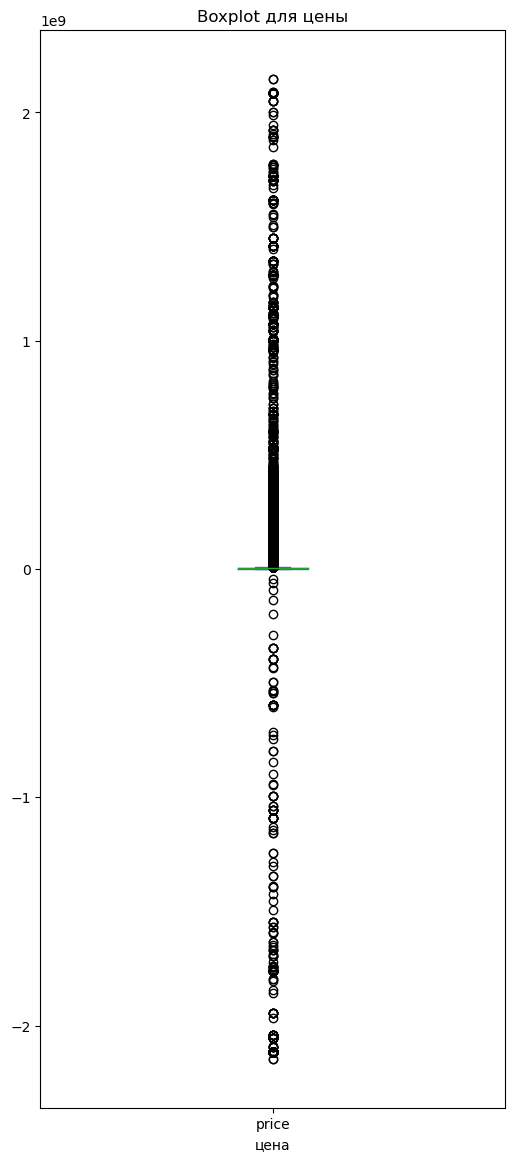

In [631]:
# Посмотрим распределение цен на недвижимость
plt.figure(figsize=(6, 14))
df['price'].plot(kind='box')
plt.title('Boxplot для цены')
plt.xlabel('цена')
plt.show()

In [632]:
df['price'].describe()

count    5.471384e+06
mean     4.421749e+06
std      2.150861e+07
min     -2.144967e+09
25%      1.950000e+06
50%      2.992000e+06
75%      4.810369e+06
max      2.147484e+09
Name: price, dtype: float64

In [633]:
df[df['price'] <= 0]['price'].count()

388

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">
    
__ВЫВОД__:
* Есть отрицательные значения стоимости недвижимости(их 388 штук), что невозможно
* Наблюдается довольно большое число выбросов

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">
Я приняла решение удалить выбросы после 1 и 99 процентиля. Таким образом мы избавились от отрицательных значений.

In [634]:
percentile_99 = df['price'].quantile(0.99)
percentile_01 = df['price'].quantile(0.01)
df = df[df['price'] <= percentile_99]
df = df[df['price'] >= percentile_01]
df['price'].describe()

count    5.365086e+06
mean     3.991348e+06
std      3.205511e+06
min      7.500000e+05
25%      1.950000e+06
50%      2.990000e+06
75%      4.770000e+06
max      2.405000e+07
Name: price, dtype: float64

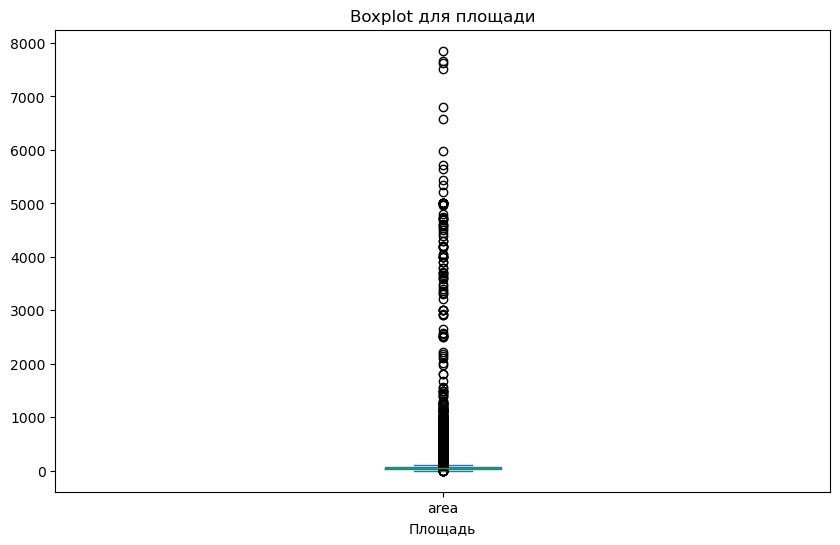

In [635]:
#Посмотрим распределение площадей недвижимости
plt.figure(figsize=(10, 6))
df['area'].plot(kind='box')
plt.title('Boxplot для площади')
plt.xlabel('Площадь')
plt.show()

In [636]:
df['area'].describe()

count    5.365086e+06
mean     5.319689e+01
std      3.010900e+01
min      2.200000e-01
25%      3.810000e+01
50%      4.802000e+01
75%      6.300000e+01
max      7.856000e+03
Name: area, dtype: float64

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">
Я приняла решение удалить выбросы после 1 и 99 процентиля. 

In [637]:
percentile_99 = df['area'].quantile(0.99)
percentile_01 = df['area'].quantile(0.01)
df = df[df['area'] <= percentile_99]
df = df[df['area'] >= percentile_01]
df['area'].describe()

count    5.260689e+06
mean     5.228863e+01
std      1.860832e+01
min      2.000000e+01
25%      3.850000e+01
50%      4.802000e+01
75%      6.290000e+01
max      1.260000e+02
Name: area, dtype: float64

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

* Из данных можно предположить, что мы говорим о российском рынке жилой площади, так как есть столбец площадь кухни, то есть размер площади недвижимости ограничен
* Хотя после удаления выбросов значительно поменялось максимальное и минимальное возможное значение площади, однако среднее и медианое значение практически не поменялись
* Здесь и далее я буду исходить из предположения, что данные собраны по рынку квартир

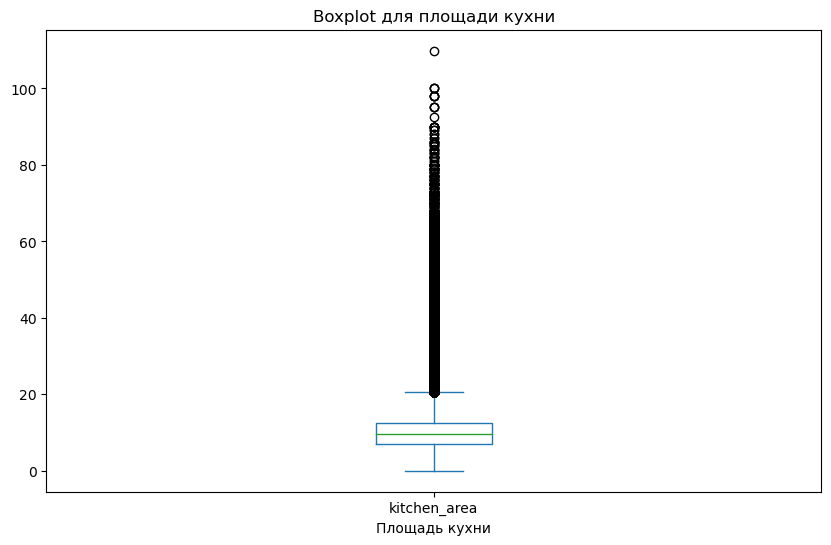

In [638]:
#Посмотрим распределение площади кухни
plt.figure(figsize=(10, 6))
df['kitchen_area'].plot(kind='box')
plt.title('Boxplot для площади кухни')
plt.xlabel('Площадь кухни')
plt.show()

In [639]:
df['kitchen_area'].describe()

count    5.016912e+06
mean     1.044441e+01
std      4.932055e+00
min      1.000000e-02
25%      7.000000e+00
50%      9.640000e+00
75%      1.240000e+01
max      1.098800e+02
Name: kitchen_area, dtype: float64

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

* Согласно найденным мной данным кухня в квартире должна быть не меньше 5 кв метров
* Чаще всего площадь кухни не превышает 35 кв метров

In [640]:
# Удалим строки, где площадь кухни меньше 5 кв метро или больше 35 кв метров
df = df[df['kitchen_area'] >= 5]
df = df[df['kitchen_area'] <= 35]
df['kitchen_area'].describe()

count    4.846594e+06
mean     1.055514e+01
std      4.427676e+00
min      5.000000e+00
25%      7.100000e+00
50%      1.000000e+01
75%      1.251000e+01
max      3.500000e+01
Name: kitchen_area, dtype: float64

In [641]:
# Проверим данный на дупликаты
df.duplicated().sum()

212258

In [642]:
df = df.drop_duplicates()

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">
Нет причин сохранять дупликаты

In [643]:
df.shape

(4634336, 10)

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">
После предобработки данных осталось 4 634 336 строки в датасете

[К навигации](#0)

### <a class="anchor" id="2"></a> Добавление данных из датасета region.csv

In [644]:
region = pd.read_csv('region.csv')
region.head(1)

,code,reg_name
0,2661,Санкт-Петербург


In [645]:
region['code'].nunique()

83

In [646]:
region.columns = ['region', 'reg_name']

In [647]:
df['region'].nunique()

84

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">
Количество кодов в регионах в датасете о недвижимости, и о регионов не совпадает. Прежде, чем их соедининять нам стоит изучить проблему

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">
Я выяснила, что коды регионов в датасете region - это строки. А также, что у региона Республика Крым два соответвующих ему кода

In [648]:
region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   region    83 non-null     object
 1   reg_name  83 non-null     object
dtypes: object(2)
memory usage: 1.4+ KB


In [649]:
region[region['region'] == '7873, 6937']

,region,reg_name
36,"7873, 6937",Республика Крым


In [650]:
# Удалим эту строку, чтобы заменить ее двумя
region.drop(36, inplace = True)
region.reset_index(drop=True)

,region,reg_name
0,2661,Санкт-Петербург
1,3446,Ленинградская область
2,3,Москва
3,81,Московская область
4,2843,Краснодарский край
...,...,...
77,16705,Магаданская область
78,69,Еврейская автономная область
79,4963,Приморский край
80,1901,Сахалинская область


In [651]:
# Создаем новые строки
new_row = pd.DataFrame({'region':['7873','6973'], 'reg_name':['Республика Крым','Республика Крым']})
region = pd.concat([region, new_row], ignore_index=True)

In [652]:
region['region'] = region['region'].astype('int') #Меняем строчный тип данных на числовой

In [653]:
data = pd.merge(df, region, on = 'region', how = 'left')#Выбираем левосторонее соединение, чтобы сохранить все строки из таблицы df
data.head(1)

,price,date,region,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name
0,6050000,2018-02-19,2661,Панельный,8,10,3,82.6,10.8,1,Санкт-Петербург


In [654]:
data['reg_name'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4634336 entries, 0 to 4634335
Series name: reg_name
Non-Null Count    Dtype 
--------------    ----- 
4630143 non-null  object
dtypes: object(1)
memory usage: 35.4+ MB


In [655]:
data = data.drop('region', axis=1)
data.head(1)

,price,date,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name
0,6050000,2018-02-19,Панельный,8,10,3,82.6,10.8,1,Санкт-Петербург


<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">
    
__ВЫВОДЫ__:
    
* Мы добавили данные из датасета region
* Удалили столбец с кодами регионов

[К навигации](#0)

### <a class="anchor" id="3"></a> Заполните пропуски в столбце kitchen_area

In [656]:
#Посмотрим есть ли корреляция между площадью кухни и площадью квартиры
data['area'].corr(data['kitchen_area'], method = 'spearman')

0.4528577527725004

Существует умеренная прямая связь между площадью кухни и площадью квартиры

In [657]:
#Посмотрим есть ли корреляция между площадью кухни и количеством комнат
data['rooms'].corr(data['kitchen_area'], method = 'spearman')

0.11100323567683935

Существует слабая прямая связь между площадью кухни и количеством комнат

In [658]:
#Посмотрим есть ли корреляция между площадью и количеством комнат
data['area'].corr(data['rooms'], method = 'spearman')

0.8099470800043658

Существует сильная прямая связь между площадью и количеством комнат

In [659]:
st.pointbiserialr(data['kitchen_area'], data['object_type'])[0]

-0.27033390762685294

Существует слабая обратная связь между типом рынка и площадью кухни

In [660]:
data['kitchen_area'].corr(data['levels'], method = 'spearman')

0.4291065471564214

Существует умеренная прямая связь между площадью кухни и количеством этажей в здании 

In [661]:
data['area'].describe()

count    4.634336e+06
mean     5.272116e+01
std      1.838540e+01
min      2.000000e+01
25%      3.900000e+01
50%      4.894000e+01
75%      6.300000e+01
max      1.260000e+02
Name: area, dtype: float64

In [662]:
# Разделим недвижимость на категории в зависимости от площади кваритры
data['area_category'] =  pd.cut(data['area'],
                          bins=[10, 30, 50, 70, 90, 110, 140], # или переменными т.к. могут измениться значения
                          labels=['от 10 до 30 кв метров', 'от 30 до 50 кв метров', 'от 50 до 70 кв метров', 'от 70 до 90 кв метров', 'от 90 до 110 кв метров', 'от 110 до 140 кв метров'],
                         )
data.head(1)

,price,date,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,area_category
0,6050000,2018-02-19,Панельный,8,10,3,82.6,10.8,1,Санкт-Петербург,от 70 до 90 кв метров


In [663]:
data.groupby('area_category')['kitchen_area'].median()

area_category
от 10 до 30 кв метров       6.0
от 30 до 50 кв метров       9.0
от 50 до 70 кв метров      10.0
от 70 до 90 кв метров      12.8
от 90 до 110 кв метров     15.0
от 110 до 140 кв метров    17.0
Name: kitchen_area, dtype: float64

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">
    
Заполним пропуски в столбце kitchen_area медиаными(так как наши площади имеют правосторонее распределение) значениями площади кухни, для квартир по категориям площади

In [664]:
data['kitchen_area'].fillna(data.groupby(['area_category'])['kitchen_area'].transform('median'), inplace = True)

In [665]:
data[data['kitchen_area'].isna()]

,price,date,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,area_category


<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">
    
__ВЫВОДЫ__:
    
* Мы провели исследование от чего может зависеть площадь кухни, и выяснили наиболее значимый признак(площадь квартиры)
* Мы заполнили пропуски в столбце kitchen_area

[К навигации](#0)

### <a class="anchor" id="4"></a> Исследуйте рынок недвижимости в РФ за представленный период.

In [666]:
data['price_per_square'] = round(data['price']/data['area'], 2)

<Axes: >

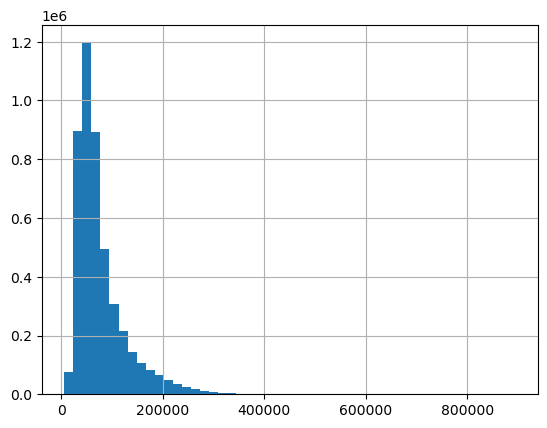

In [667]:
data['price_per_square'].hist(bins = 50)

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">
    Цена за квадратный метр имеет правосторонее распределение

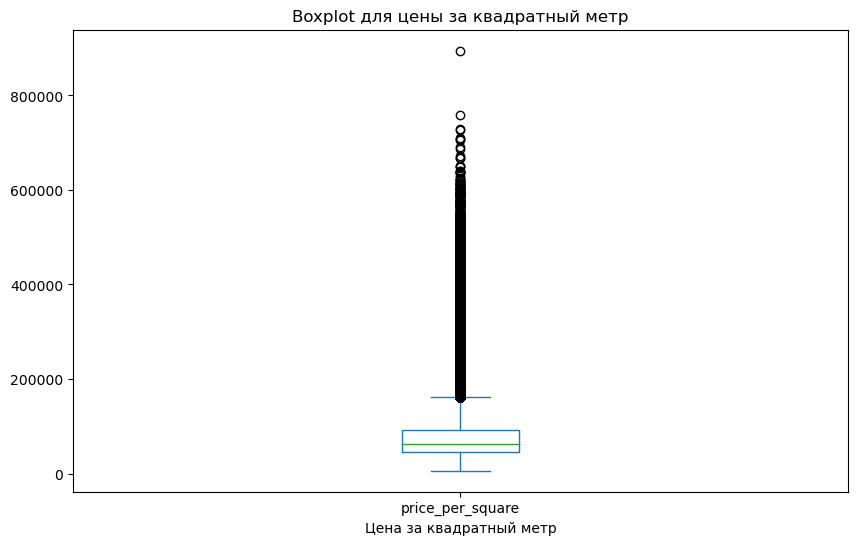

In [668]:
plt.figure(figsize=(10, 6))
data['price_per_square'].plot(kind='box')
plt.title('Boxplot для цены за квадратный метр')
plt.xlabel('Цена за квадратный метр')
plt.show()

In [669]:
data['price_per_square'].describe()

count    4.634336e+06
mean     7.676323e+04
std      4.972530e+04
min      6.198350e+03
25%      4.470609e+04
50%      6.184211e+04
75%      9.155049e+04
max      8.946577e+05
Name: price_per_square, dtype: float64

In [670]:
percentile_99 = data['price_per_square'].quantile(0.99)
percentile_01 = data['price_per_square'].quantile(0.01)
data = data[data['price_per_square'] <= percentile_99]
data = data[data['price_per_square'] >= percentile_01]

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

* Удалила выбросы в цене за квадратный метр, так как нет объясняющей причины

In [671]:
data['price_per_square'].describe()

count    4.541794e+06
mean     7.503028e+04
std      4.393708e+04
min      2.177778e+04
25%      4.500000e+04
50%      6.184211e+04
75%      9.057072e+04
max      2.600000e+05
Name: price_per_square, dtype: float64

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

* Средняя цена за квадратный метр равна 75 030 рублей

    
__Посмотрим как распределяется цена за квадратный метр по годам__

In [672]:
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month

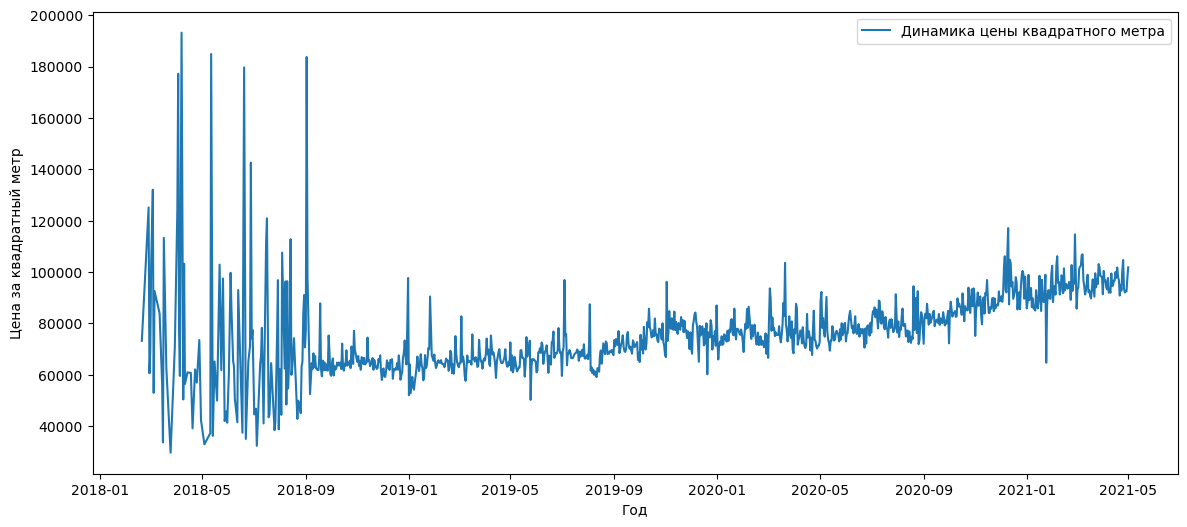

In [673]:
report = data.groupby('date')['price_per_square'].mean()
plt.figure(figsize =(14, 6))
plt.plot(report, label = 'Динамика цены квадратного метра')
plt.xlabel('Год')
plt.ylabel('Цена за квадратный метр')
plt.legend()
plt.show()

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

__ВЫВОД__:
    
* В 2018 году средняя цена за квадратный метр колебалась сильнее всего
* В последующие годы можно предположить, что средняя  цена за квадратный метр росла
* Данные за 2021 год представлены не полностью

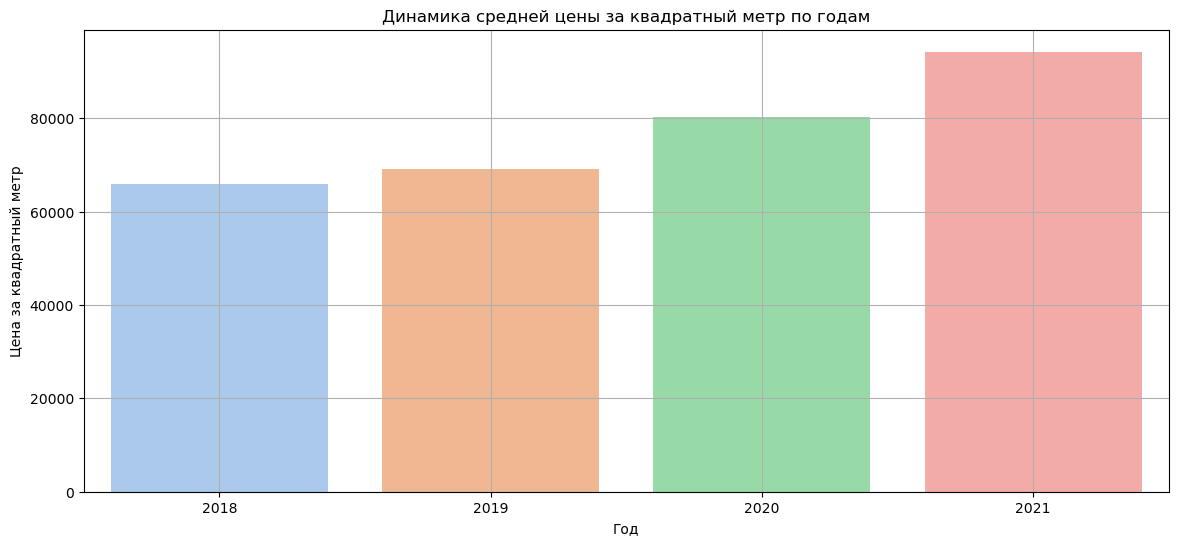

In [674]:
report = data.groupby('year')['price_per_square'].mean().reset_index()
plt.figure(figsize =(14, 6))
sns.barplot(report, x = 'year', y = 'price_per_square', palette = 'pastel').set(title = 'Динамика средней цены за квадратный метр по годам', xlabel = 'Год', ylabel = 'Цена за квадратный метр' )
plt.grid()
plt.show()

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

__ВЫВОД__:
    
* Средняя цена за квадратный метр росла
* Каждый год скорость роста стредней цены квадратного метра увеличивалась

__Посмотрим как распределяется цена за квадратный метр по категориям площади__

In [675]:
area_price = data.groupby('area_category')['price_per_square'].mean().reset_index()

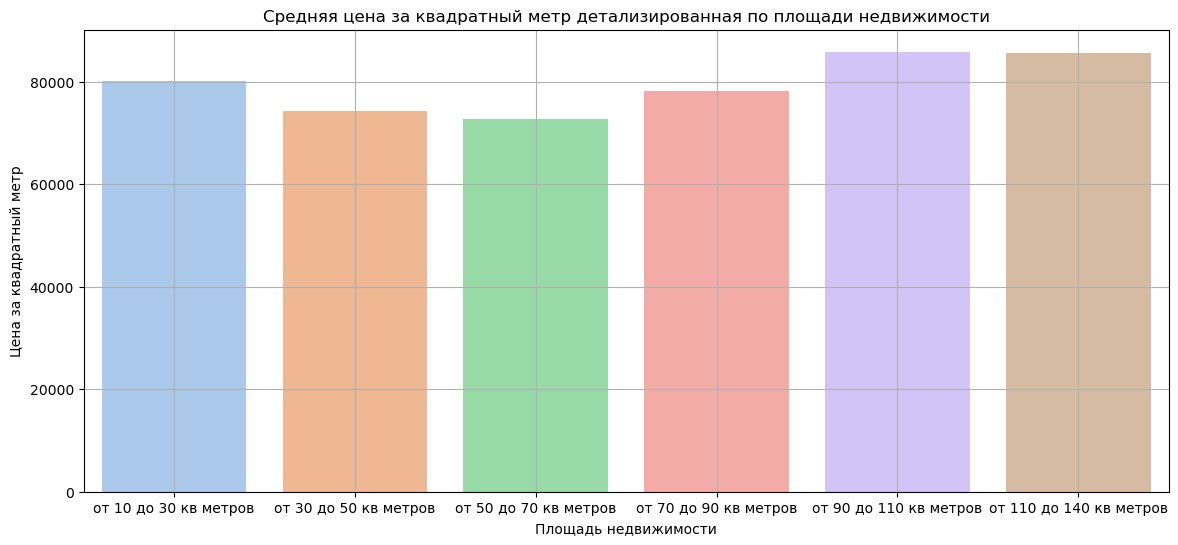

In [676]:
plt.figure(figsize =(14, 6))
sns.barplot(data = area_price, x = 'area_category', y = 'price_per_square', palette = 'pastel').set(title = 'Средняя цена за квадратный метр детализированная по площади недвижимости', xlabel = 'Площадь недвижимости', ylabel = 'Цена за квадратный метр' )
plt.grid()
plt.show()

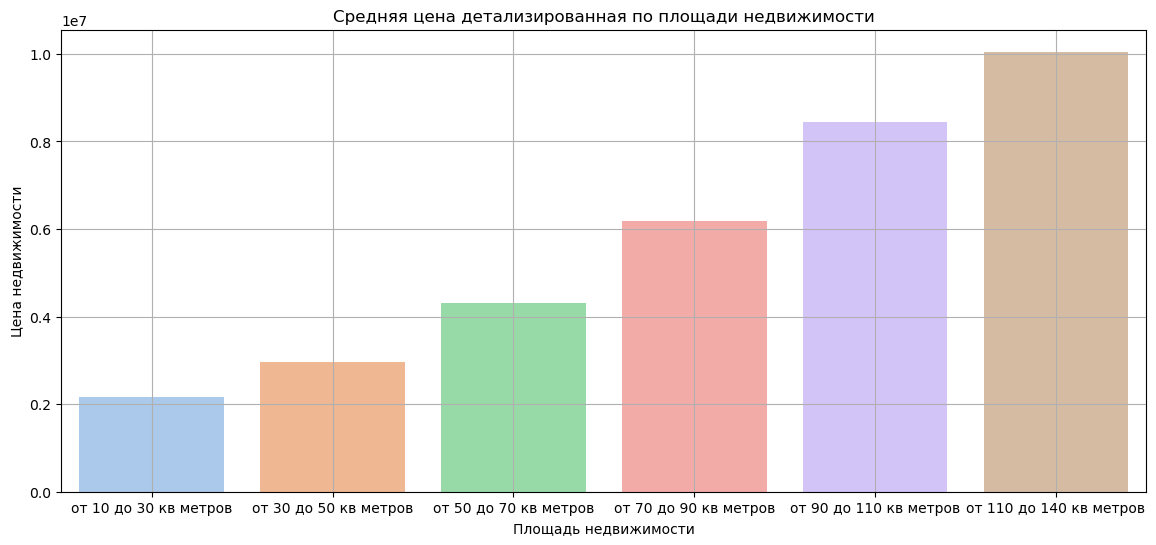

In [677]:
area_price = data.groupby('area_category')['price'].mean().reset_index()
plt.figure(figsize =(14, 6))
sns.barplot(data = area_price, x = 'area_category', y = 'price', palette = 'pastel').set(title = 'Средняя цена детализированная по площади недвижимости', xlabel = 'Площадь недвижимости', ylabel = 'Цена недвижимости' )
plt.grid()
plt.show()

In [678]:
data.groupby('area_category')['price_per_square'].count().reset_index()

,area_category,price_per_square
0,от 10 до 30 кв метров,224672
1,от 30 до 50 кв метров,2190044
2,от 50 до 70 кв метров,1410489
3,от 70 до 90 кв метров,528129
4,от 90 до 110 кв метров,148557
5,от 110 до 140 кв метров,39903


<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

__ВЫВОД__:
    
* Можно заметить, что самый дорогой квадратный метр у недвижимости площадью от 10 до 30 кв метров и у недвижимости площадью от 90 до 110 кв метров
* Несмотря, что стоимость квартир площадью от 10 до 30 кв метров самая низкая, цена за квадратный метр самая высокая
* Самый дешевый квадратный метр у средних квартир площадью от 50 до 70 кв метров
* Можно предположить, что количество недвижимости в каждой категории отображает реальную ситуацию рынке. Недвижимость с площадью от 30 до 50 кв метров и от 50 до 70 кв метров самая популярная; Скорее всего такая недвижимость и строится чаще, поэтому цены за квадратный метр ниже

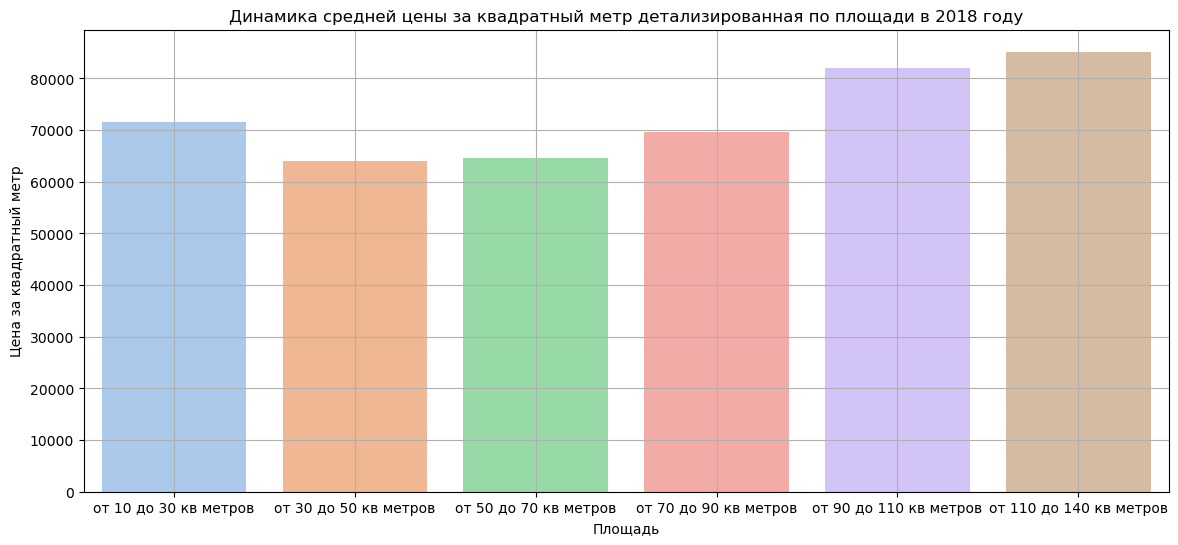

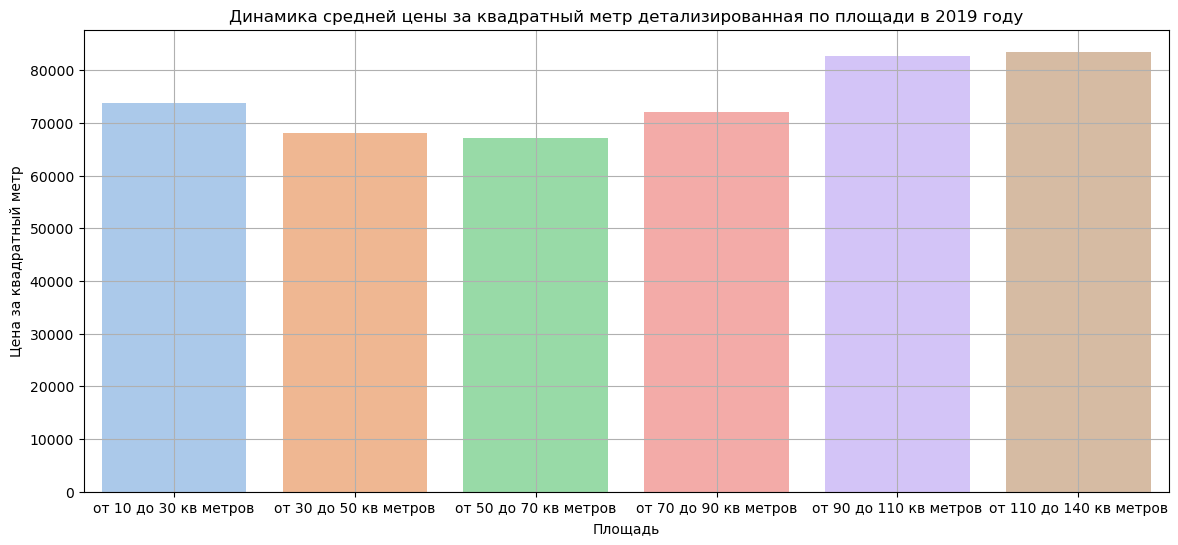

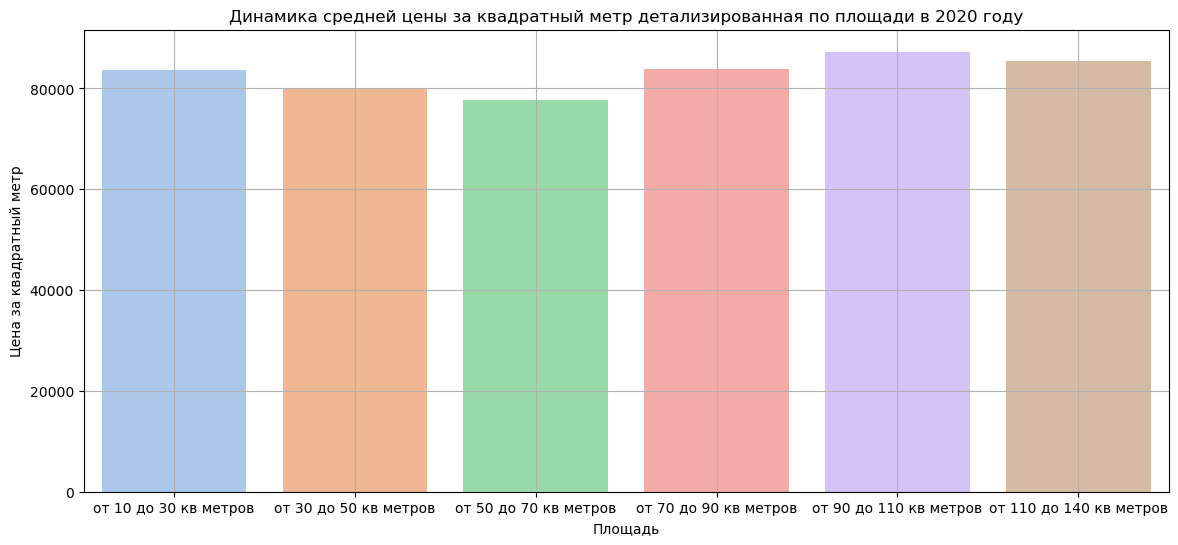

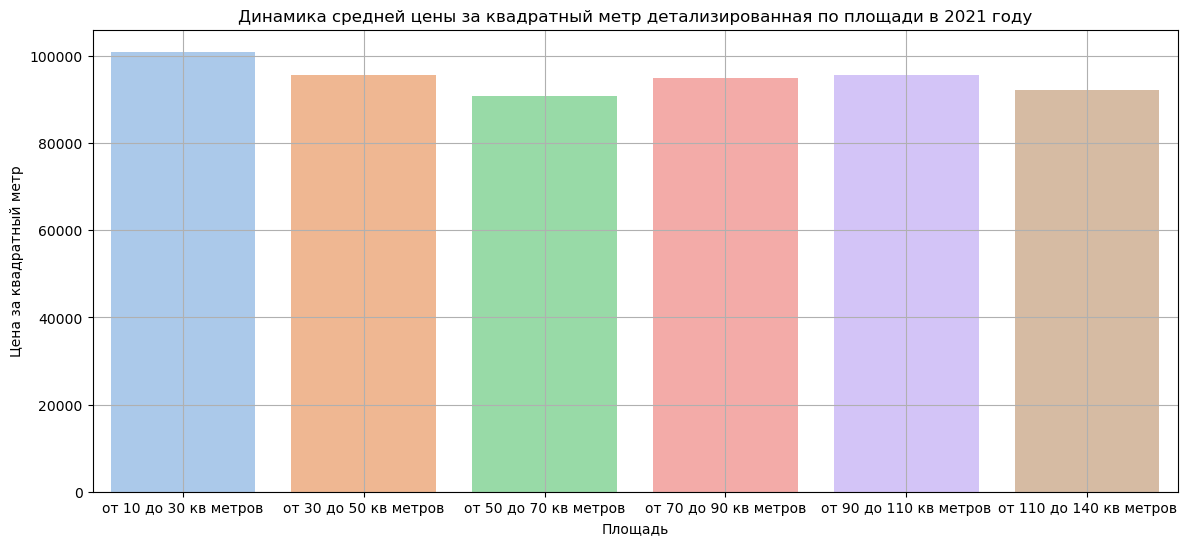

In [679]:
for x in data['year'].unique():
    report = data[data['year'] == x].groupby('area_category')['price_per_square'].mean().reset_index()
    plt.figure(figsize =(14, 6))
    sns.barplot(report, x = 'area_category', y = 'price_per_square', palette = 'pastel').set(title = f'Динамика средней цены за квадратный метр детализированная по площади в {x} году', xlabel = 'Площадь', ylabel = 'Цена за квадратный метр' )
    plt.grid()
plt.show()

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

__ВЫВОД__:
    
* В целом распределение цены за квадратный метр по категориям не различается год от года
* Квартиры дорожают в каждой категории
* Меньше всего цена квадратного метра меняется у квартир с большей площадью
* В 2021 году разница между ценами за квадратный метр в разных категориях уменьшилась



__Посмотрим как распределяется цена за квадратный метр в зависимости от этажа__

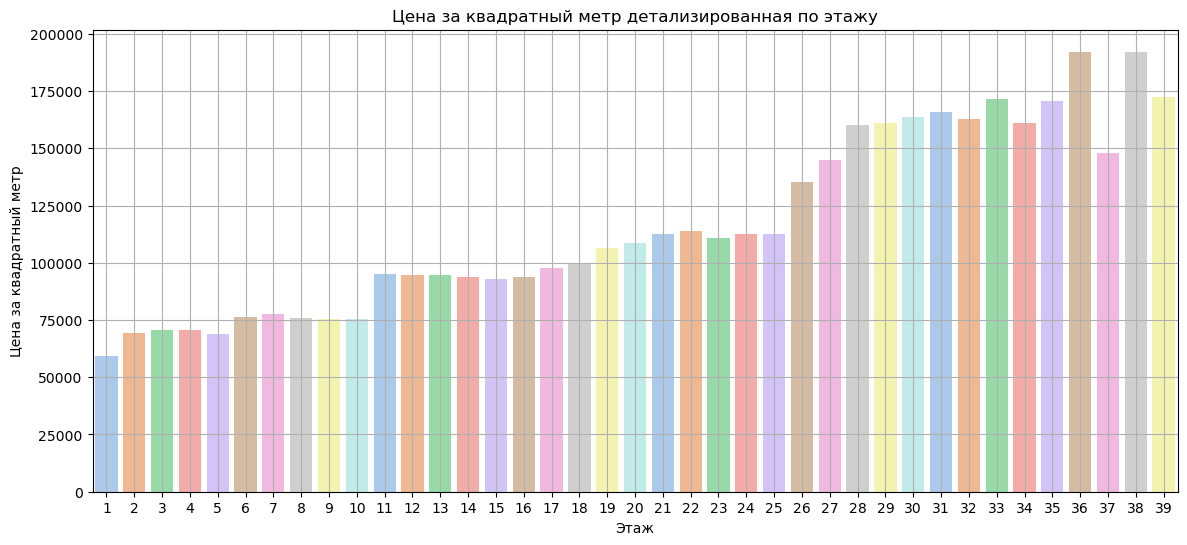

In [680]:
level_price = data.groupby('level')['price_per_square'].mean().reset_index()
plt.figure(figsize =(14, 6))
sns.barplot(data = level_price, x = 'level', y = 'price_per_square', palette = 'pastel').set(title = 'Цена за квадратный метр детализированная по этажу', xlabel = 'Этаж', ylabel = 'Цена за квадратный метр' )
plt.grid()
plt.show()

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

__ВЫВОД__:
    
* Можно заметить, что самый дорогой квадратный метр у квартир на этажах выше 25, скорее всего это более новые дома, выше классом. Также это может быть связано, что более высокие дома строится в крупных городах, где цены в целом выше
* Самый дешевый квадратный метр у недвижимости на первом этаже
* Можно сказать, что стоимость квадратного метра растет вместе с ростом этажа

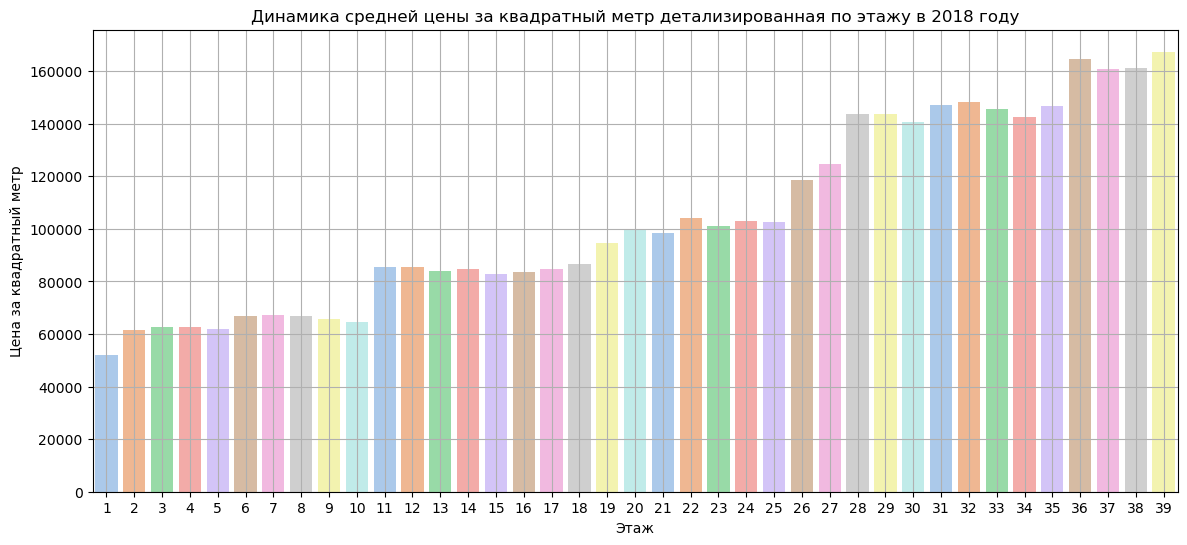

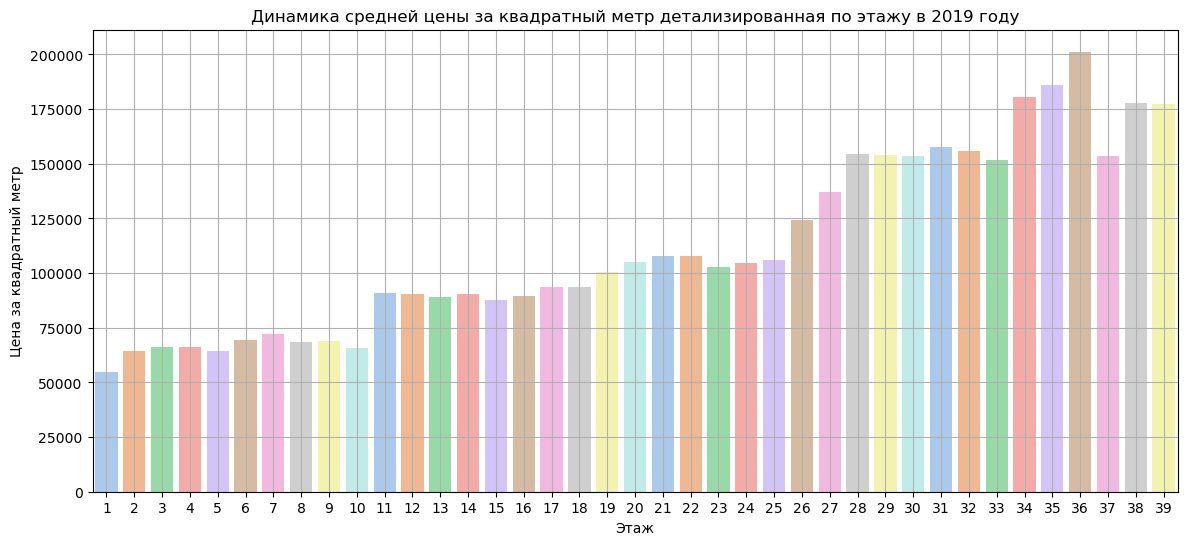

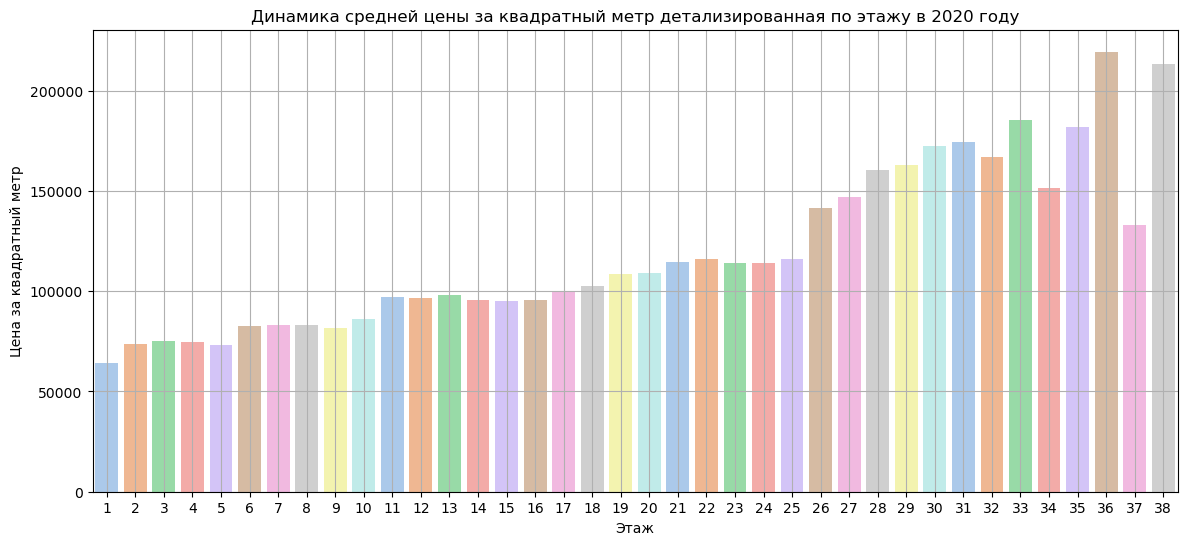

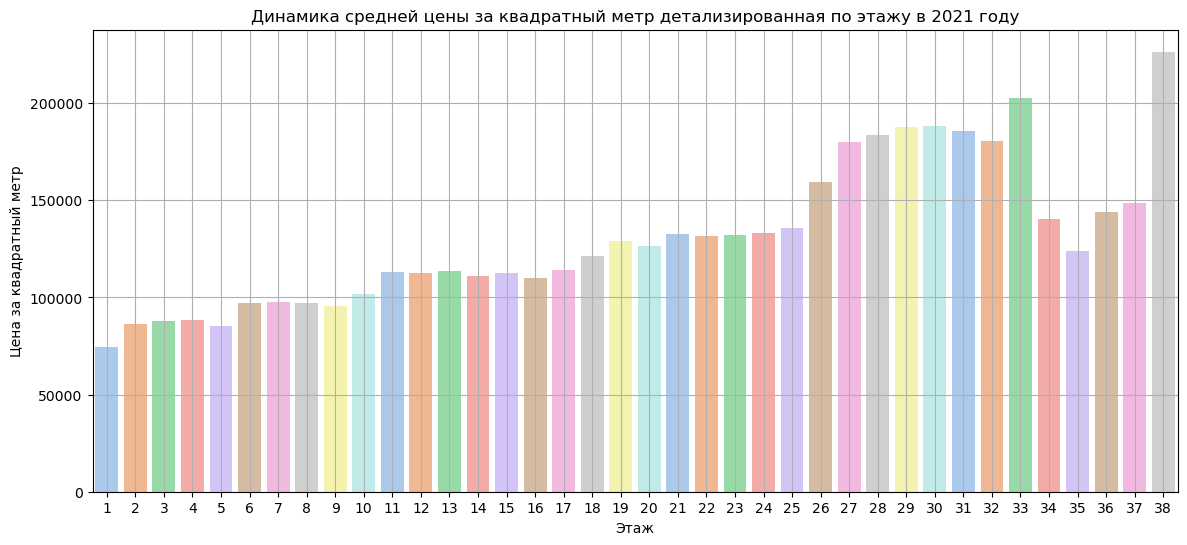

In [681]:
for x in data['year'].unique():
    report = data[data['year'] == x].groupby('level')['price_per_square'].mean().reset_index()
    plt.figure(figsize =(14, 6))
    sns.barplot(report, x = 'level', y = 'price_per_square', palette = 'pastel').set(title = f'Динамика средней цены за квадратный метр детализированная по этажу в {x} году', xlabel = 'Этаж', ylabel = 'Цена за квадратный метр' )
    plt.grid()
plt.show()

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

__ВЫВОД__:
    
* В целом распределение цены за квадратный метр по этажу не различается год от года
* Квартиры дорожают в каждой категории

__Посмотрим как распределяется цена за квадратный метр в зависимости от количества этажей в доме__

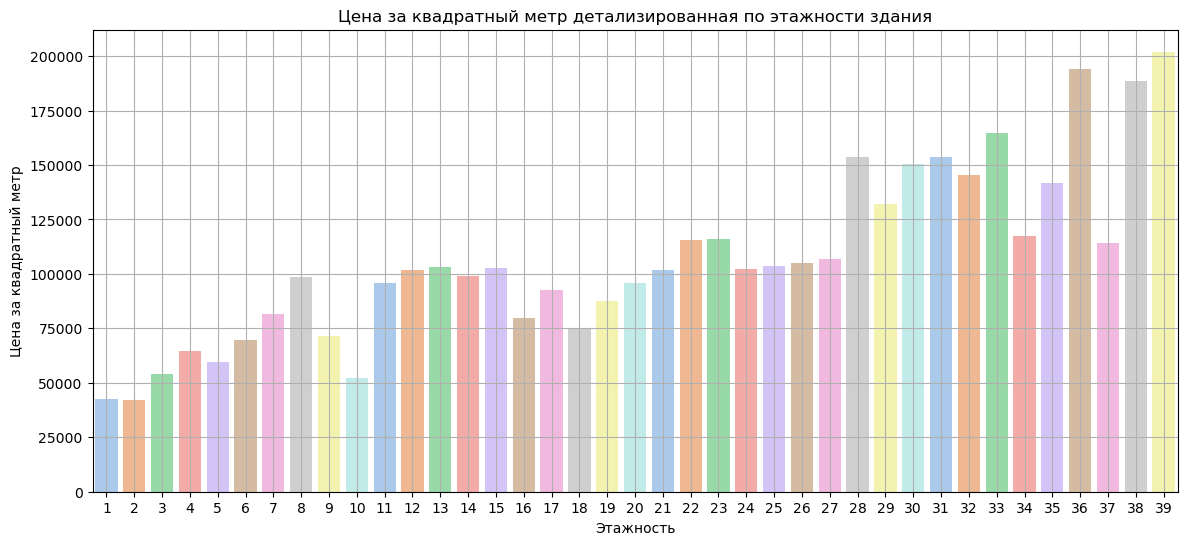

In [682]:
levels_price = data.groupby('levels')['price_per_square'].mean().reset_index()
plt.figure(figsize =(14, 6))
sns.barplot(data = levels_price, x = 'levels', y = 'price_per_square', palette = 'pastel').set(title = 'Цена за квадратный метр детализированная по этажности здания', xlabel = 'Этажность', ylabel = 'Цена за квадратный метр' )
plt.grid()
plt.show()

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

__ВЫВОД__:
    
* Можно заметить, что самый дорогой квадратный метр в здании в 39 этажей
* Самый дешевый квадратный метр в 1 и 2 этажных домах
* Можно заметить резкое падение цены квадратного метра в 10 этажных домах, скорее всего это связано с тем, что это либо старые дома; либо наоборот самые бюджетные новостройки
* Скорее всего зданий с количеством этажей больше 20 - это новые здания

In [683]:
data[data['levels'] > 30].groupby('object_type')['levels'].count()

object_type
0    25461
1     3968
Name: levels, dtype: int64

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

* Потверждение, что в домах с количеством этажей больше 30, большая часть недвижимости продается на первичном рынке

In [684]:
data[data['levels'] == 10 ].groupby('object_type')['levels'].count()

object_type
0    275255
1    406100
Name: levels, dtype: int64

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

* В основном недвижимость в 10 этажных домах продается на вторичном рынке

__Посмотрим как распределяется цена за квадратный метр в зависимости от количества комнат__

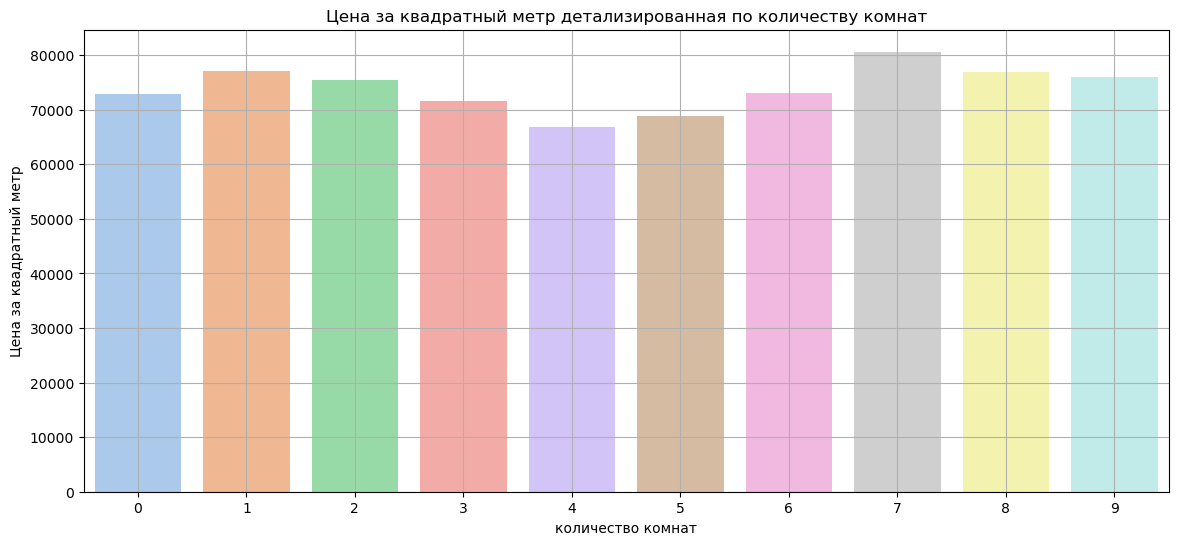

In [685]:
rooms_price = data.groupby('rooms')['price_per_square'].mean().reset_index()
plt.figure(figsize =(14, 6))
sns.barplot(data = rooms_price, x = 'rooms', y = 'price_per_square', palette = 'pastel').set(title = 'Цена за квадратный метр детализированная по количеству комнат', xlabel = 'количество комнат', ylabel = 'Цена за квадратный метр' )
plt.grid()
plt.show()

In [686]:
data.query('rooms > 5')

,price,date,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,area_category,price_per_square,year,month
12926,4200000,2018-09-10,кирпичный,5,9,9,64.0,7.0,1,Московская область,от 50 до 70 кв метров,65625.00,2018,9
14844,4150000,2018-09-10,кирпично-монолитный,2,2,6,105.0,15.0,0,Краснодарский край,от 90 до 110 кв метров,39523.81,2018,9
31540,2000000,2018-09-13,Панельный,4,5,6,56.0,6.0,1,Самарская область,от 50 до 70 кв метров,35714.29,2018,9
35515,13000000,2018-09-13,кирпичный,3,9,6,113.0,10.0,1,Санкт-Петербург,от 110 до 140 кв метров,115044.25,2018,9
38494,2450700,2018-09-14,блочный,6,16,7,63.0,15.5,1,Краснодарский край,от 50 до 70 кв метров,38900.00,2018,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594199,16000000,2021-04-28,кирпичный,4,5,6,108.0,11.1,1,Санкт-Петербург,от 90 до 110 кв метров,148148.15,2021,4
4618615,2800000,2021-04-30,кирпичный,8,16,6,42.0,14.0,1,Алтайский край,от 30 до 50 кв метров,66666.67,2021,4
4618911,5500000,2021-04-30,кирпичный,3,4,6,103.0,9.0,1,Республика Татарстан,от 90 до 110 кв метров,53398.06,2021,4
4623672,3260000,2021-04-30,кирпичный,4,9,9,64.0,26.0,0,Псковская область,от 50 до 70 кв метров,50937.50,2021,4


<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">
    
Я думаю количество комнат больше 4 в наших данных - это аномалия. Площадь предствленной недвижимости не больше 126 кв метров. Удалим эти строки.

In [687]:
data = data[data['rooms'] < 5]

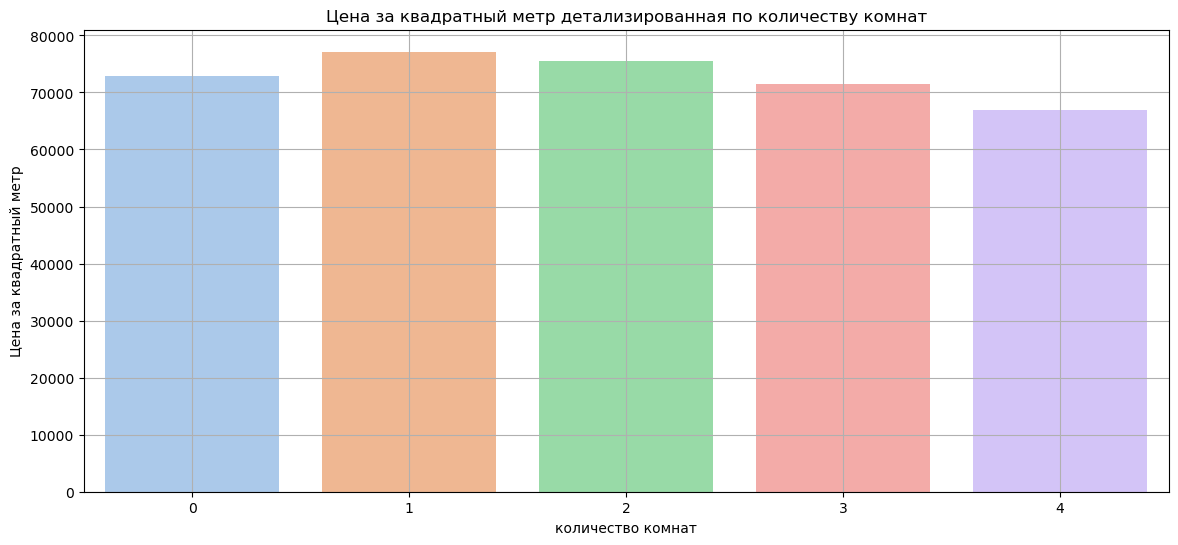

In [688]:
rooms_price = data.groupby('rooms')['price_per_square'].mean().reset_index()
plt.figure(figsize =(14, 6))
sns.barplot(data = rooms_price, x = 'rooms', y = 'price_per_square', palette = 'pastel').set(title = 'Цена за квадратный метр детализированная по количеству комнат', xlabel = 'количество комнат', ylabel = 'Цена за квадратный метр' )
plt.grid()
plt.show()

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

__ВЫВОД__:
    
* Можно заметить, что самый дорогой квадратный метр у однакомнатных квартир
* Самый дешевый квадратный метр у четырехкомнатных квартир
* Начиная с однокомнатных квартир при увеличении количества комнат цена квадратного метра начинает падать 

__Удалим аномалию в данных, где количество комнат не соответствует площади__

In [689]:
data = data.drop(data.query('area_category == "от 10 до 30 кв метров" and rooms > 1 ').index)

In [690]:
data = data.drop(data.query('area_category == "от 30 до 50 кв метров" and rooms > 2 ').index)

In [691]:
data = data.drop(data.query('area_category == "от 50 до 70 кв метров" and rooms > 3 ').index)


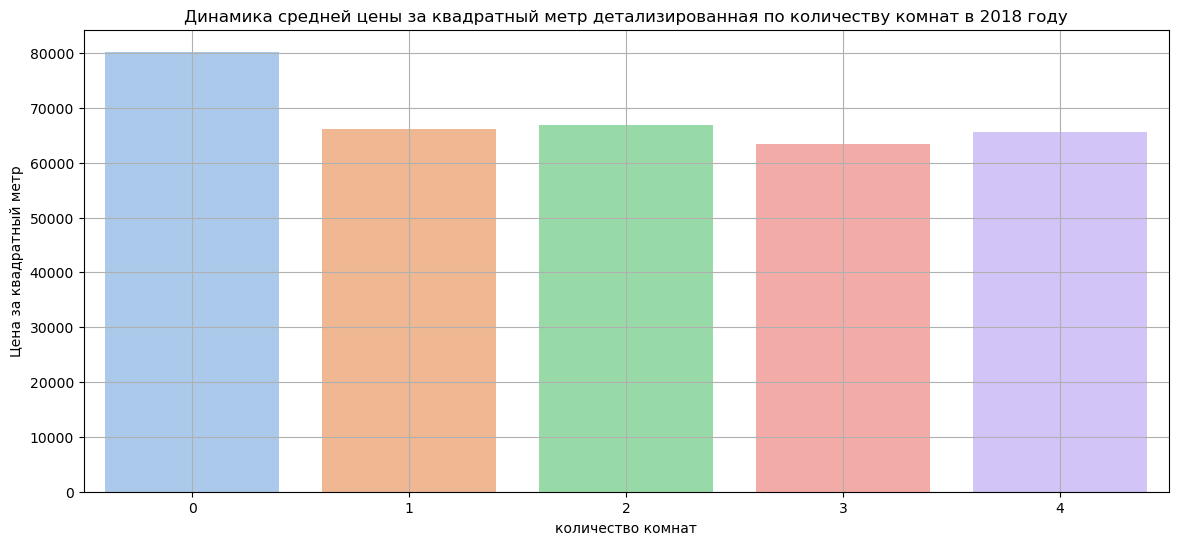

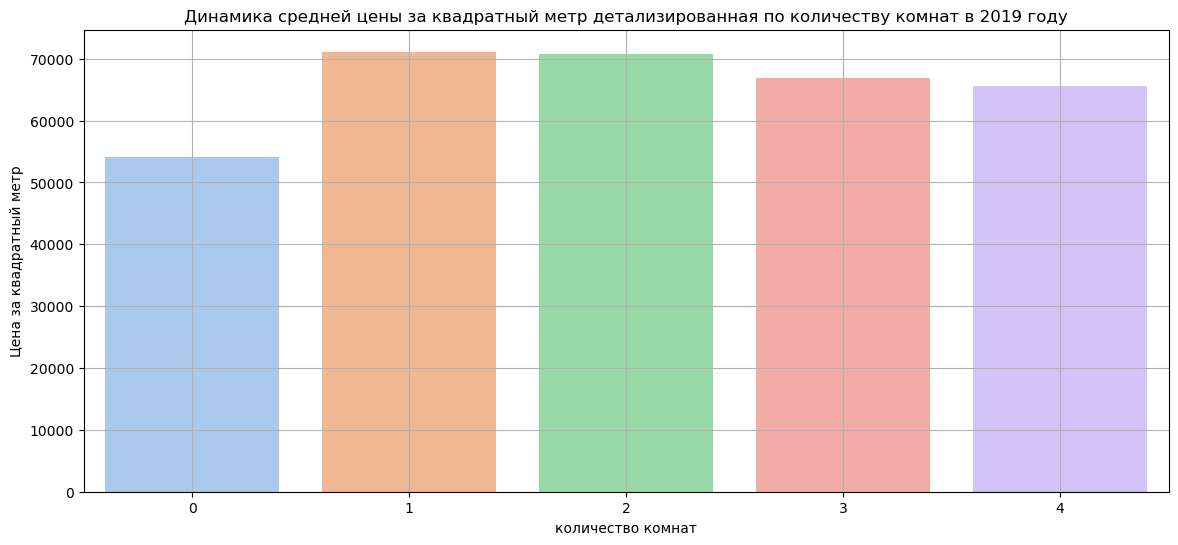

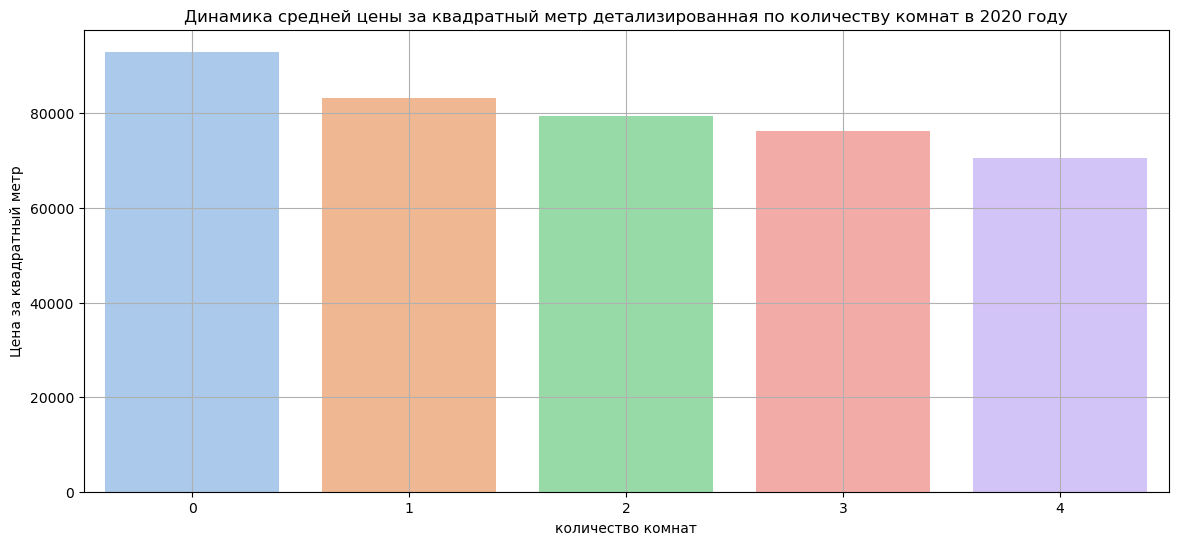

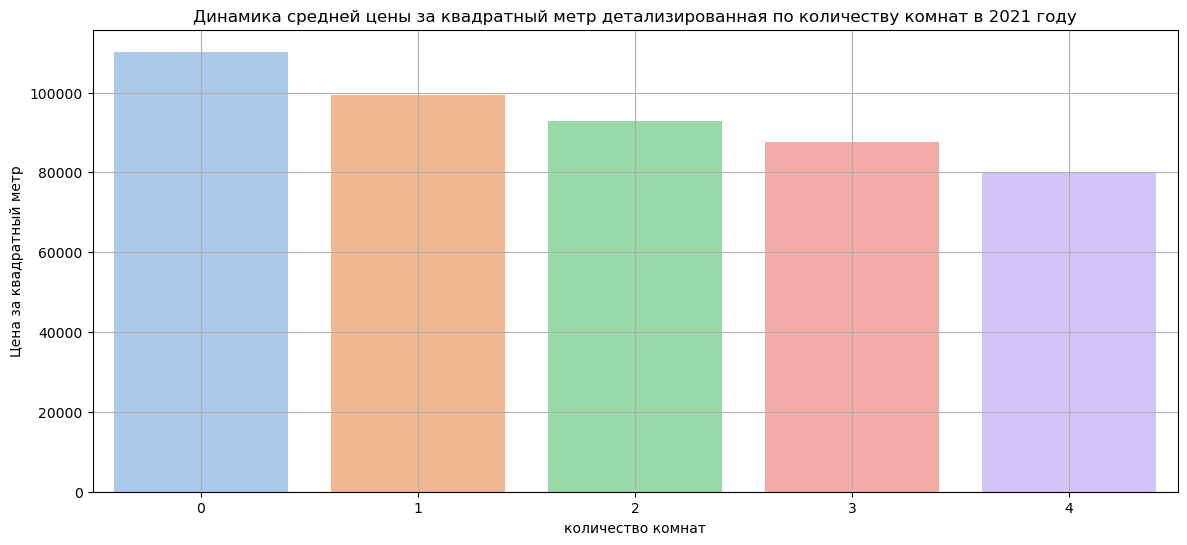

In [692]:
for x in data['year'].unique():
    report = data[data['year'] == x].groupby('rooms')['price_per_square'].mean().reset_index()
    plt.figure(figsize =(14, 6))
    sns.barplot(report, x = 'rooms', y = 'price_per_square', palette = 'pastel').set(title = f'Динамика средней цены за квадратный метр детализированная по количеству комнат в {x} году', xlabel = 'количество комнат', ylabel = 'Цена за квадратный метр' )
    plt.grid()
plt.show()

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

__ВЫВОД__:
    
* В 2019 году распределение цены квадратного метра различается в зависимости от количества комнат, от других годов
* В 2019 году квартиры студии были самыми дешевыми

__10 регионов с самой низкой ценой за квадратный метр__

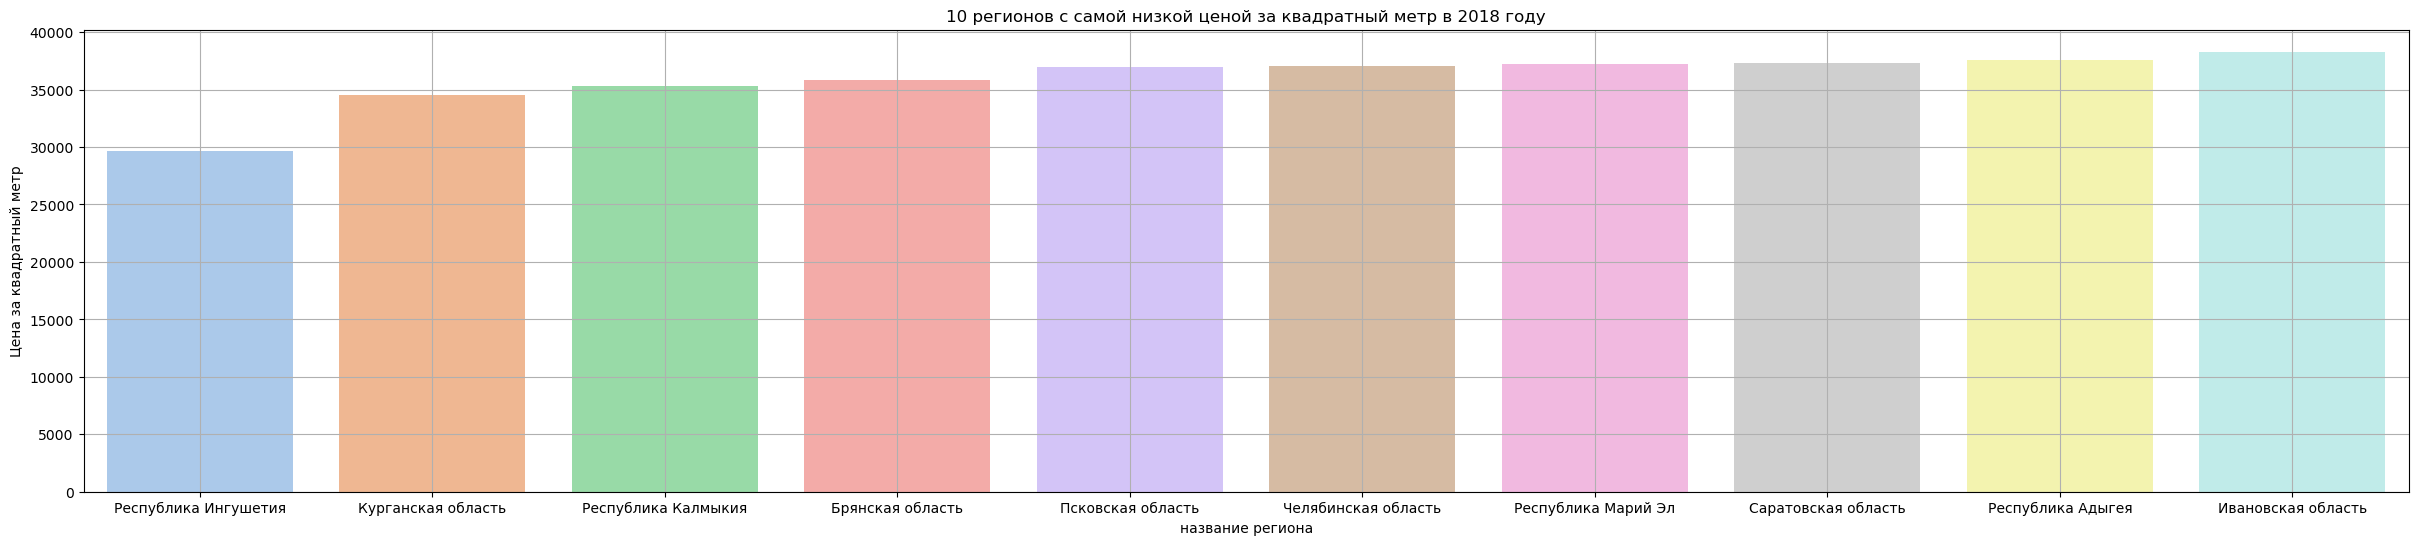

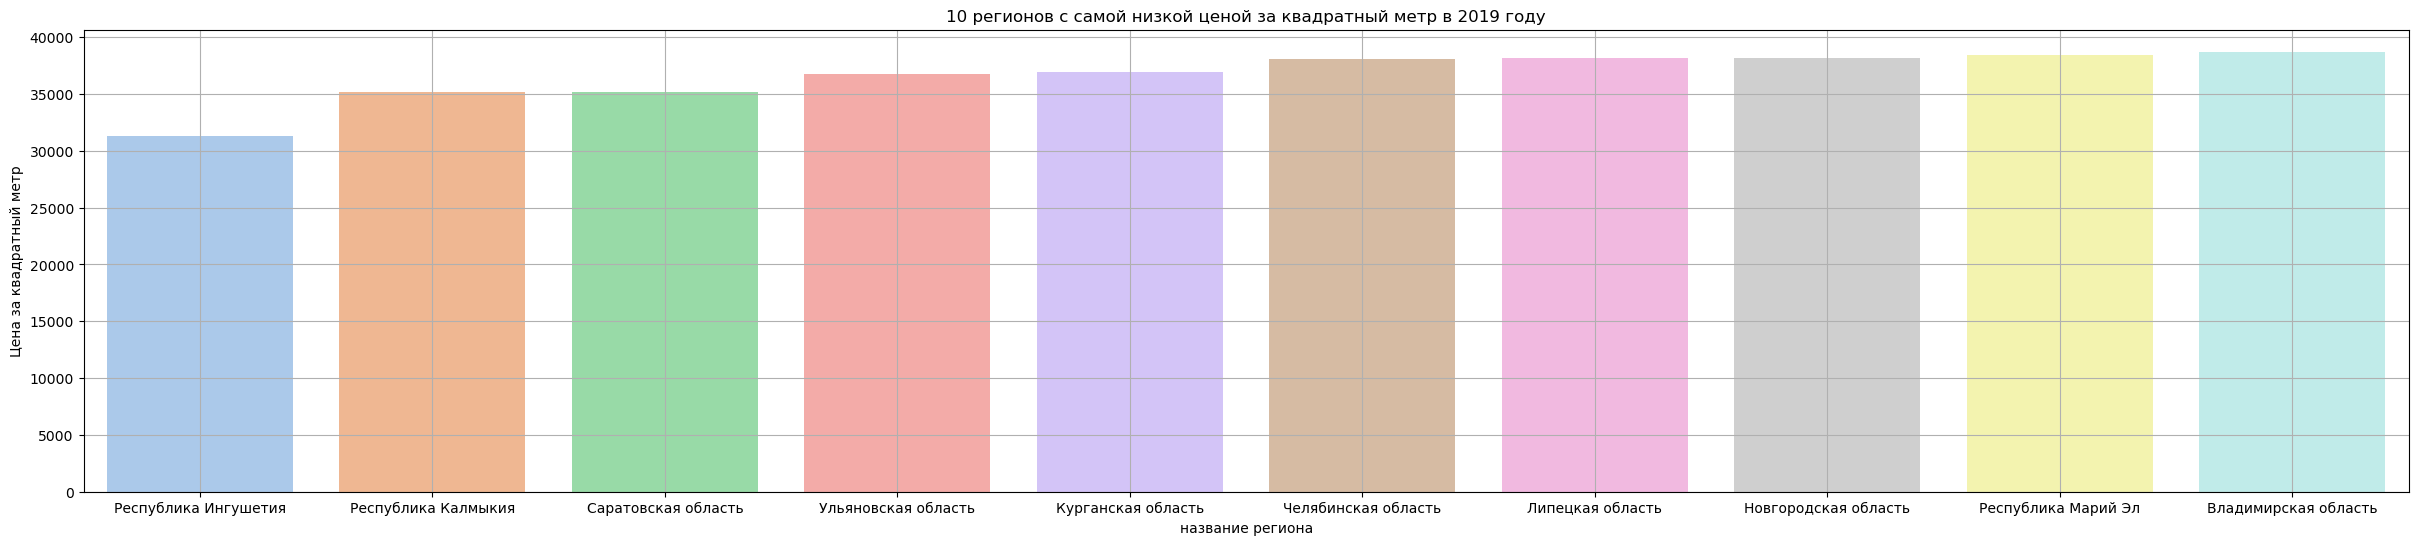

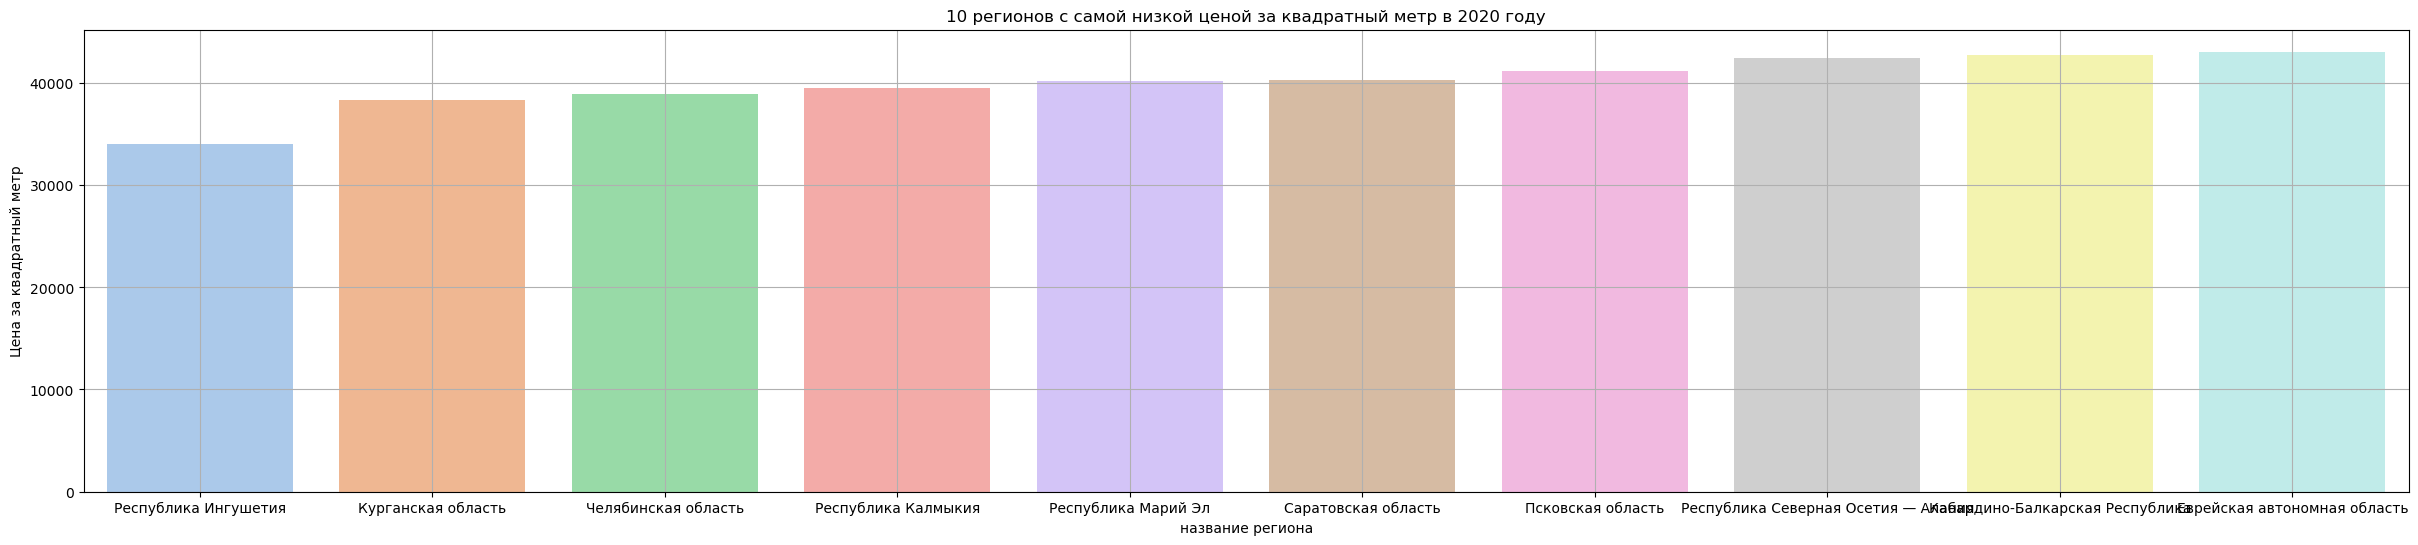

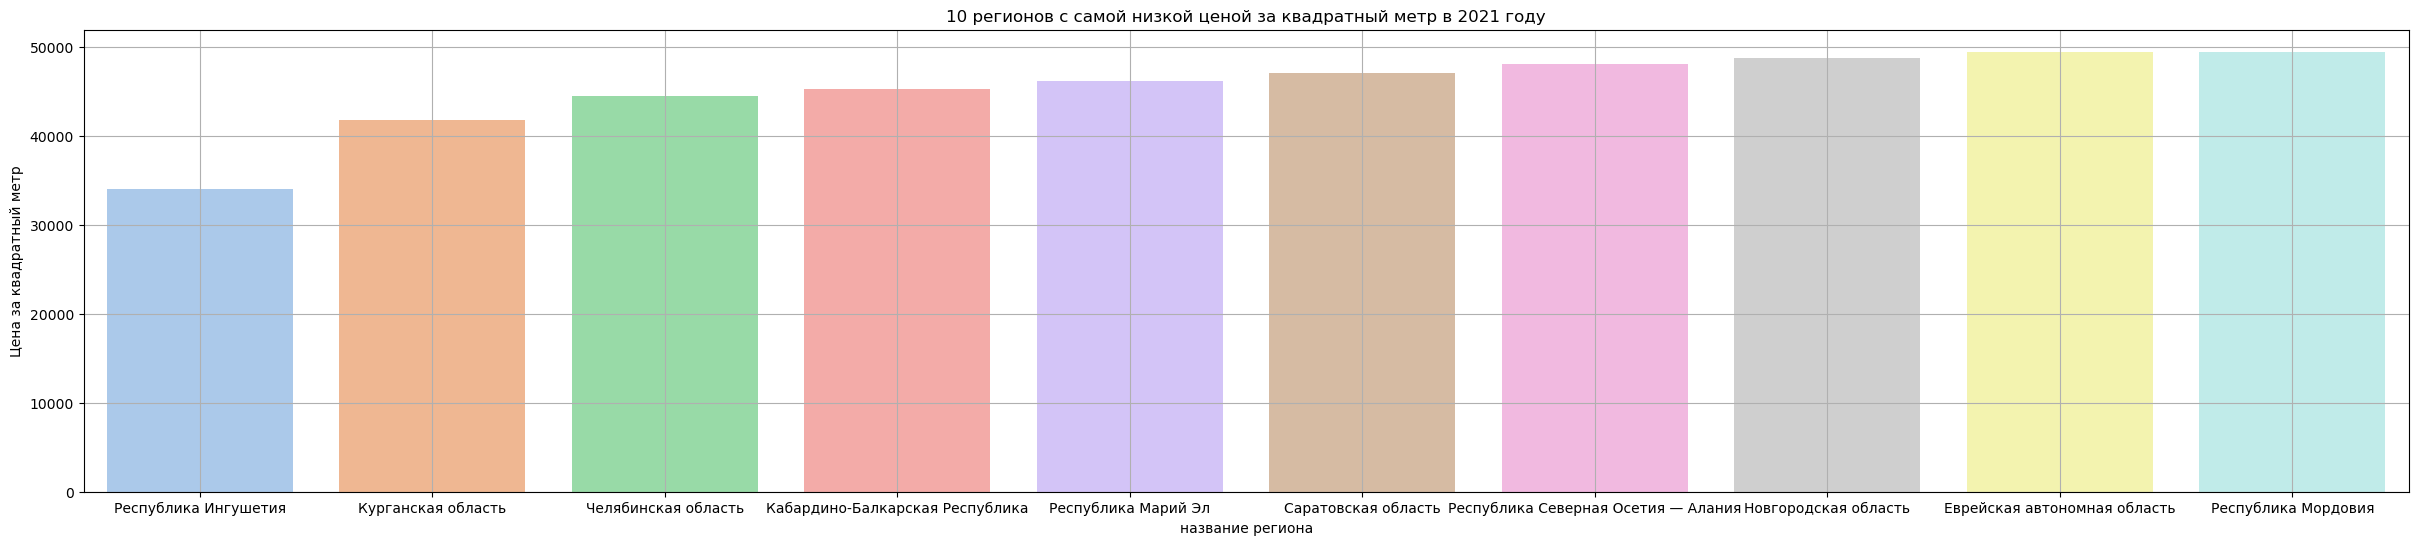

In [693]:
for x in data['year'].unique():
    report = data[data['year'] == x].groupby('reg_name')['price_per_square'].mean().reset_index().sort_values(by ='price_per_square' ).head(10)
    plt.figure(figsize =(30, 6))
    sns.barplot(report, x = 'reg_name', y = 'price_per_square', palette = 'pastel').set(title = f'10 регионов с самой низкой ценой за квадратный метр в {x} году', xlabel = 'название региона', ylabel = 'Цена за квадратный метр' )
    plt.grid()
plt.show()

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

* Состав десятки регионов с самыми дешевыми ценами за квадратный метр менялся каждый год
* Некоторые регионы(Курганская, Челябинская область) были включены каждый год


 __10 регионов с самой высокой ценой за квадратный метр__

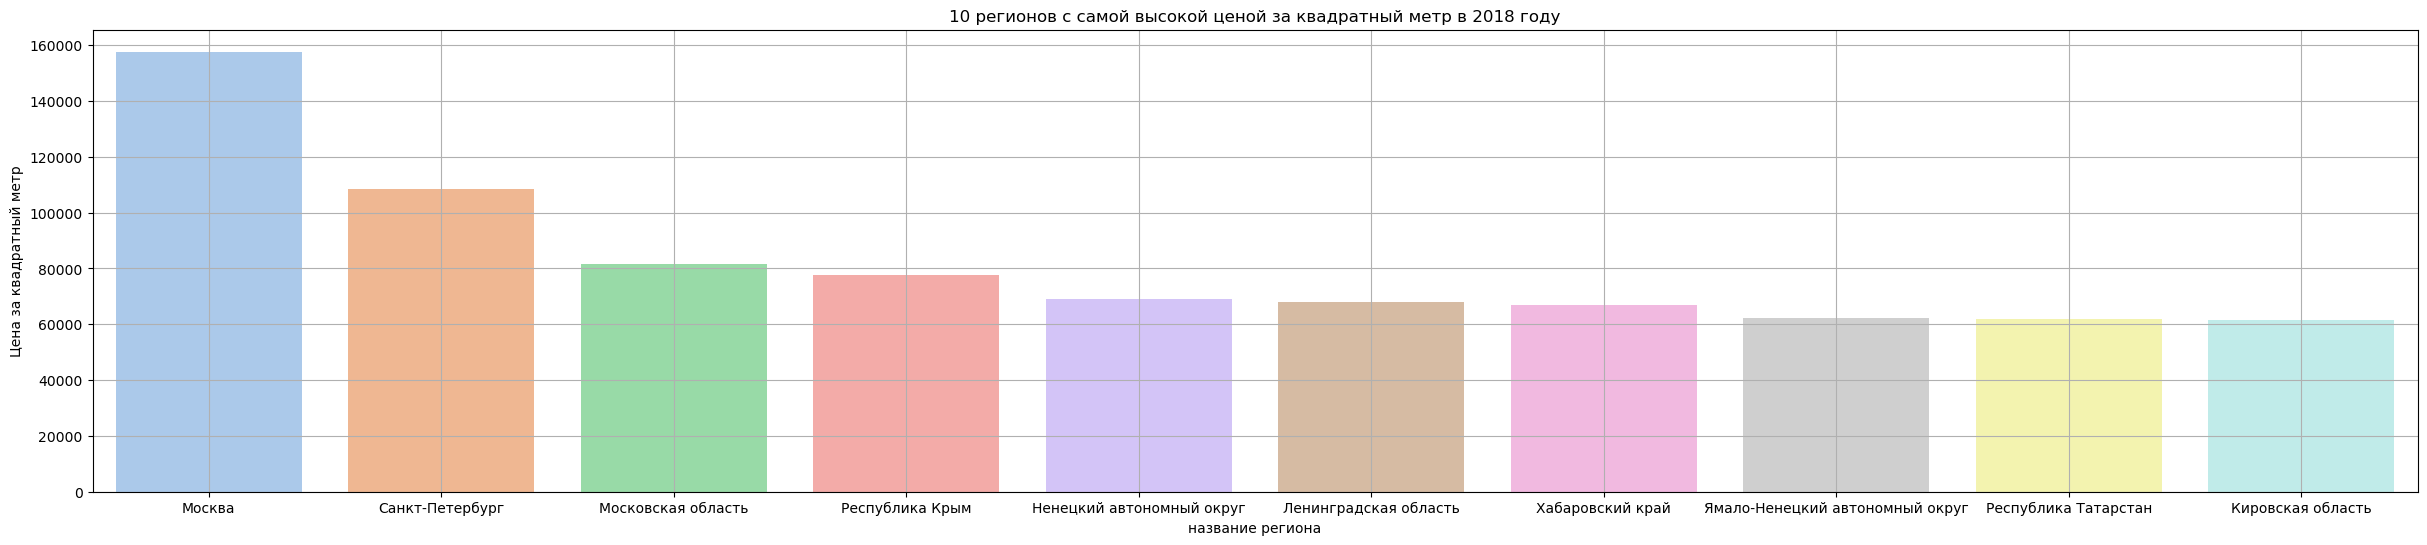

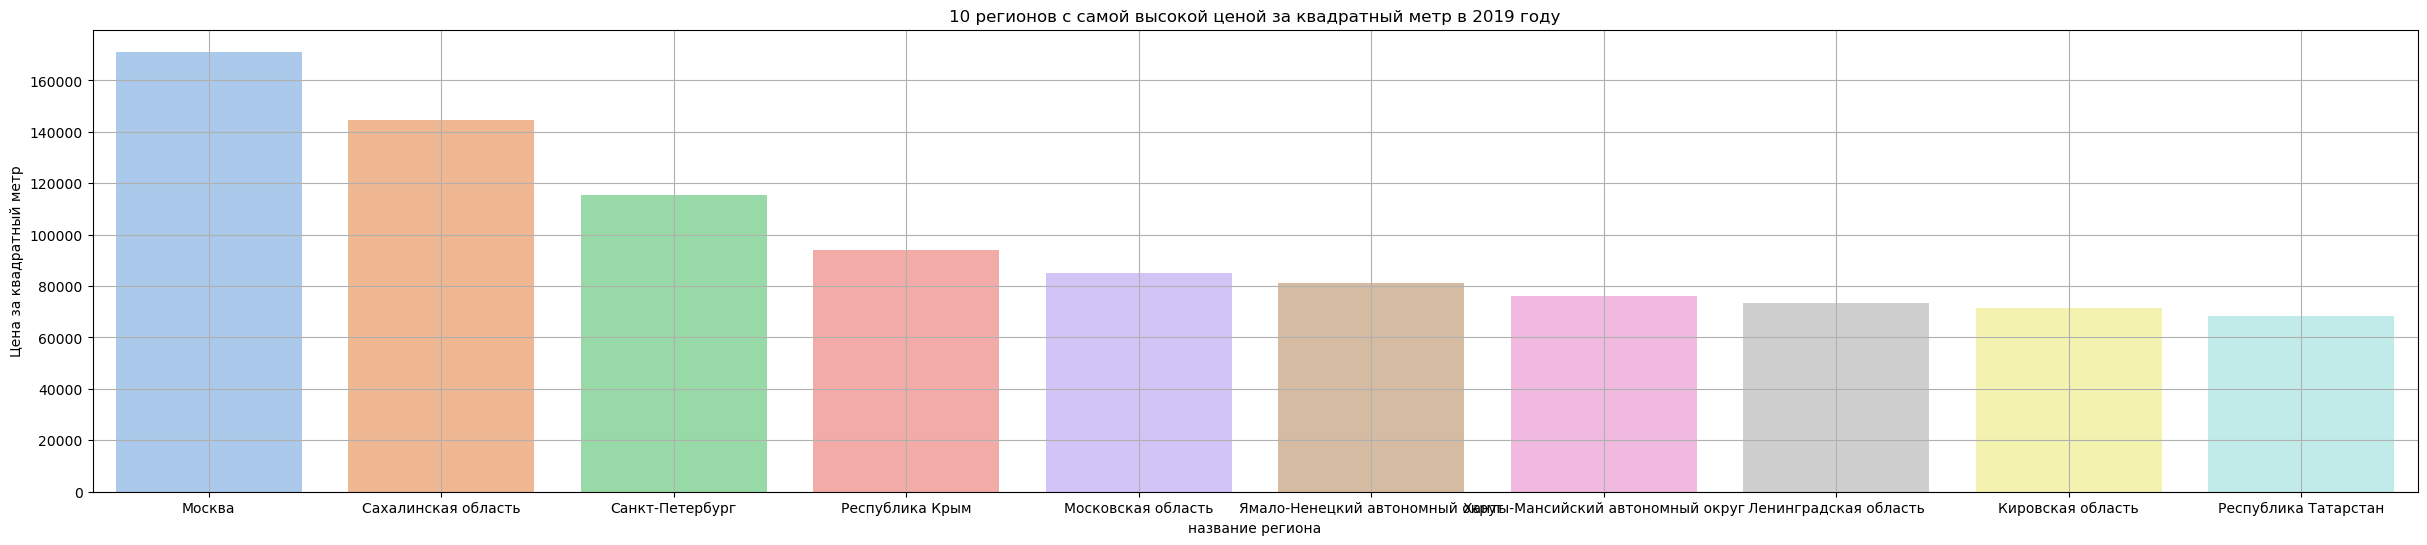

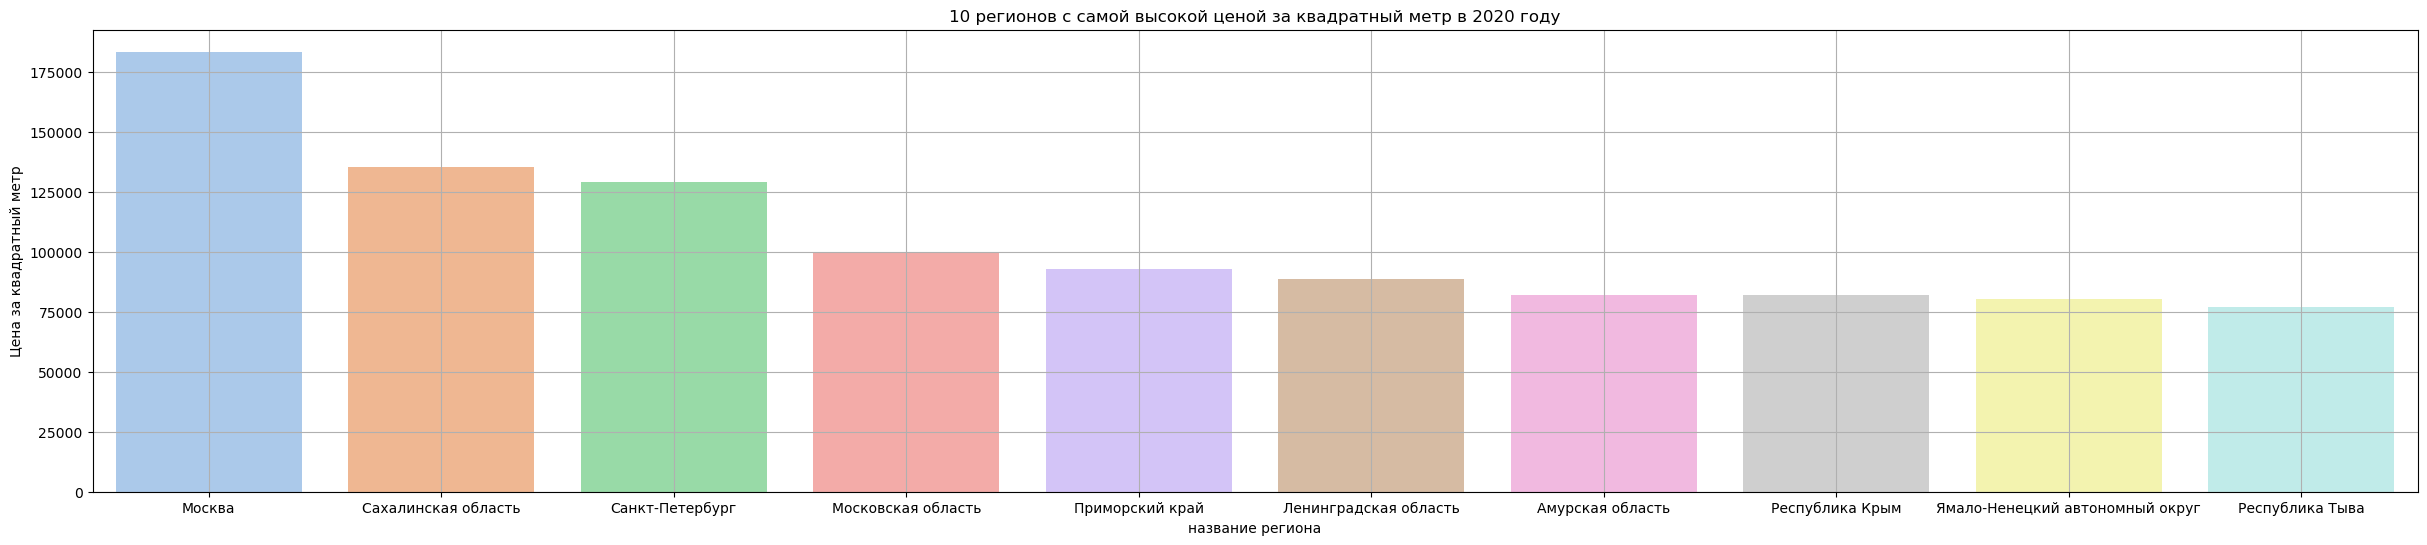

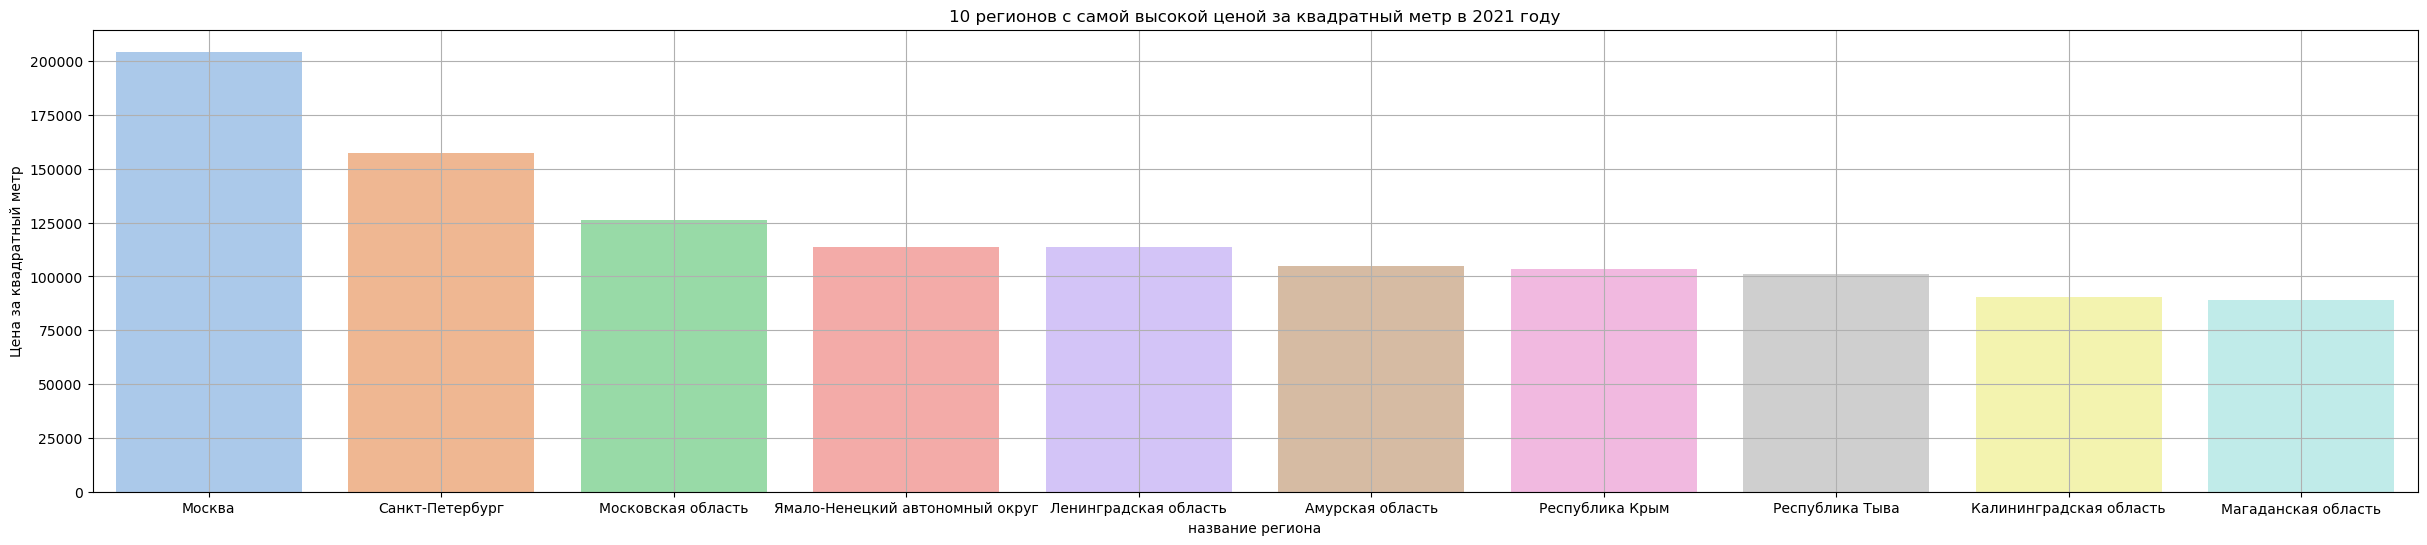

In [694]:
for x in data['year'].unique():
    report = data[data['year'] == x].groupby('reg_name')['price_per_square'].mean().reset_index().sort_values(by ='price_per_square', ascending = False).head(10)
    plt.figure(figsize =(30, 6))
    sns.barplot(report, x = 'reg_name', y = 'price_per_square', palette = 'pastel').set(title = f'10 регионов с самой высокой ценой за квадратный метр в {x} году', xlabel = 'название региона', ylabel = 'Цена за квадратный метр' )
    plt.grid()
plt.show()

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

* Самый дорогой квадратный  метр в Москве и Санкт-Петербурге
* Москва, Санкт-Петербург, московская и ленинградская области всегда входят в топ
* Квадратный метр дорогой в отдаленных регионах
* Явно заметна связь между регионом и стоимостью жилья

__Посмотрим как распределяется цена за квадратный метр в зависимости от типа здания__

In [695]:
data.query('building_type == "деревянный" and levels > 3')# В Россиии пока не развито строительство многоэтажек из дерева

,price,date,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,area_category,price_per_square,year,month
3040,5744585,2018-09-08,деревянный,7,18,1,34.7,8.4,1,Москва,от 30 до 50 кв метров,165550.00,2018,9
3041,2305692,2018-09-08,деревянный,19,21,1,39.9,11.9,1,Московская область,от 30 до 50 кв метров,57786.77,2018,9
3043,2408460,2018-09-08,деревянный,18,22,1,41.1,12.6,1,Московская область,от 30 до 50 кв метров,58600.00,2018,9
3045,2408460,2018-09-08,деревянный,17,22,1,41.1,12.6,1,Московская область,от 30 до 50 кв метров,58600.00,2018,9
3046,2074800,2018-09-08,деревянный,17,21,1,37.0,8.3,1,Московская область,от 30 до 50 кв метров,56075.68,2018,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4594327,2990000,2021-04-28,деревянный,3,17,1,34.9,8.4,0,Новосибирская область,от 30 до 50 кв метров,85673.35,2021,4
4595026,6050000,2021-04-28,деревянный,20,21,3,90.9,12.0,0,Новосибирская область,от 90 до 110 кв метров,66556.66,2021,4
4595205,5100000,2021-04-28,деревянный,8,9,2,44.0,6.0,1,Московская область,от 30 до 50 кв метров,115909.09,2021,4
4601697,5100000,2021-04-29,деревянный,3,19,0,52.4,12.5,0,Новосибирская область,от 50 до 70 кв метров,97328.24,2021,4


In [696]:
data = data.drop(data.query('building_type == "деревянный" and levels > 3').index)#Удалим деревянные дома выше 3-х этажей

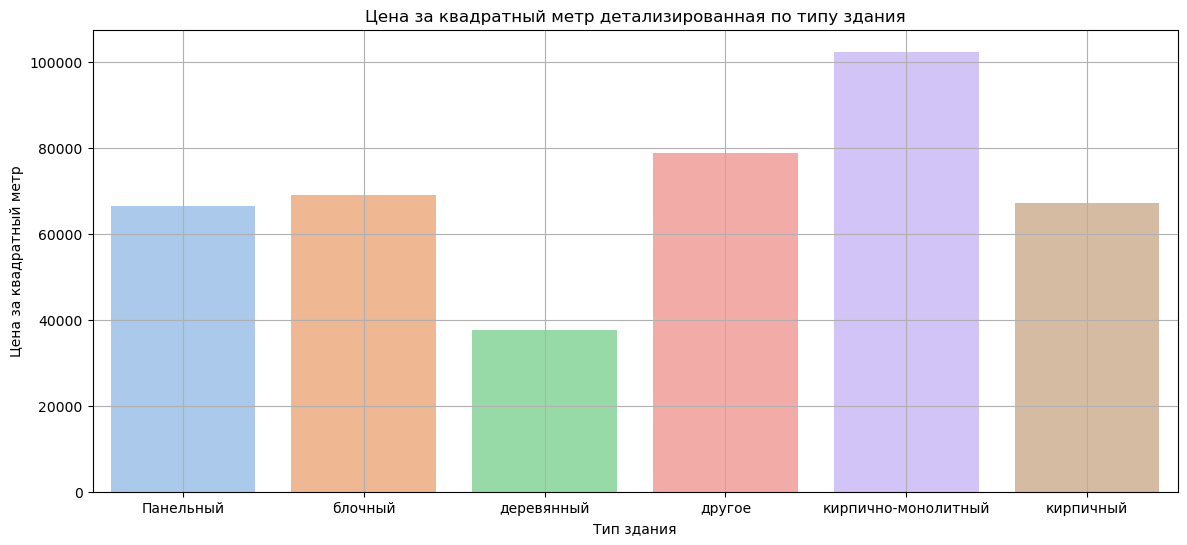

In [697]:
building_type_price = data.groupby('building_type')['price_per_square'].mean().reset_index()
plt.figure(figsize =(14, 6))
sns.barplot(data = building_type_price, x = 'building_type', y = 'price_per_square', palette = 'pastel').set(title = 'Цена за квадратный метр детализированная по типу здания', xlabel = 'Тип здания', ylabel = 'Цена за квадратный метр' )
plt.grid()
plt.show()

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

__ВЫВОД__:
    
* Можно заметить, что самый дорогой квадратный метр в кирпично-монолитных домах
* Самый дешевый квадратный метр в деревянных

__Посмотрим как распределяется цена за квадратный метр в зависимости от рынка__

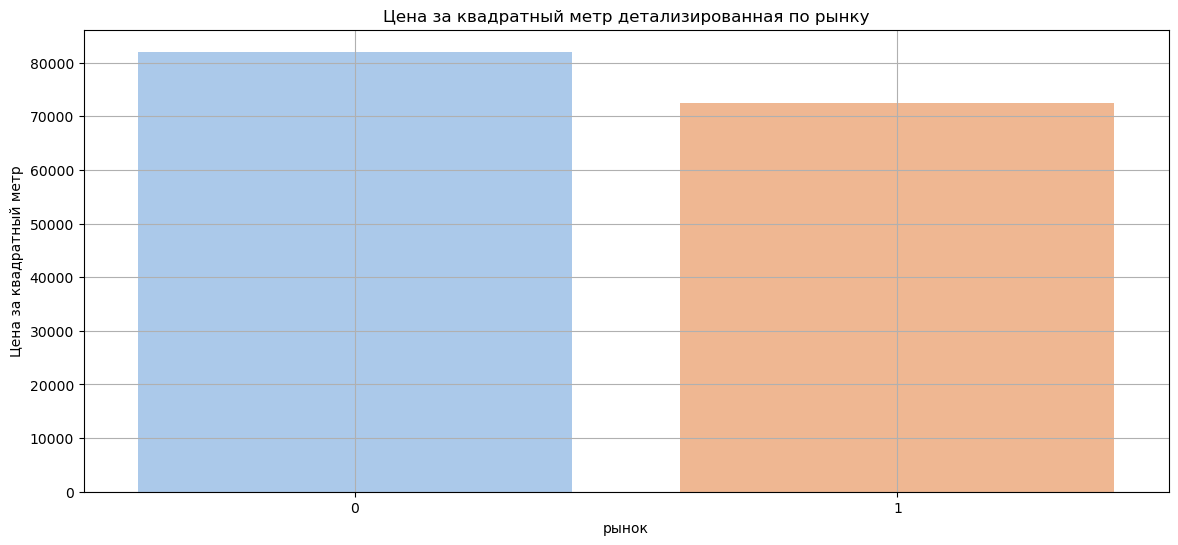

In [698]:
object_type_price = data.groupby('object_type')['price_per_square'].mean().reset_index()
plt.figure(figsize =(14, 6))
sns.barplot(data = object_type_price, x = 'object_type', y = 'price_per_square', palette = 'pastel').set(title = 'Цена за квадратный метр детализированная по рынку', xlabel = 'рынок', ylabel = 'Цена за квадратный метр' )
plt.grid()
plt.show()

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

__ВЫВОД__:
    
* Квадратный метр на первичном рынке дороже, чем на вторичном
* Однако разница около 10 тысяч рублей

__Посмотрим как распределяется цена за квадратный метр в зависимости от рынка и числа комнат__

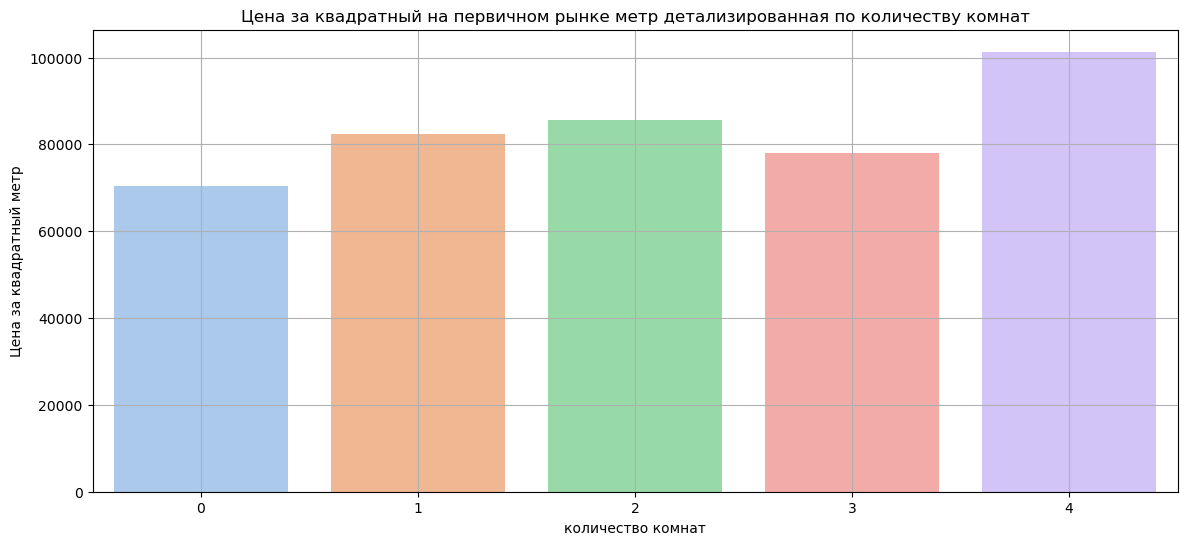

In [699]:
object_rooms = data.query('object_type == 0').groupby(['rooms'])['price_per_square'].mean().reset_index()
plt.figure(figsize =(14, 6))
sns.barplot(data = object_rooms, x = 'rooms', y = 'price_per_square', palette = 'pastel').set(title = 'Цена за квадратный на первичном рынке метр детализированная по количеству комнат', xlabel = 'количество комнат', ylabel = 'Цена за квадратный метр' )
plt.grid()
plt.show()

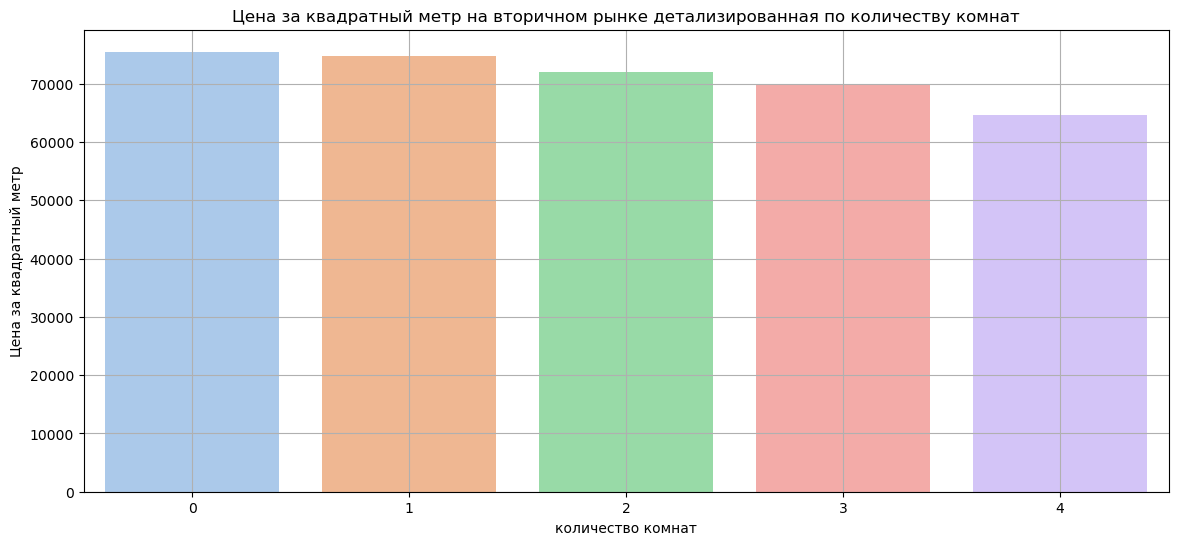

In [700]:
object_rooms = data.query('object_type == 1').groupby(['rooms'])['price_per_square'].mean().reset_index()
plt.figure(figsize =(14, 6))
sns.barplot(data = object_rooms, x = 'rooms', y = 'price_per_square', palette = 'pastel').set(title = 'Цена за квадратный метр на вторичном рынке детализированная по количеству комнат', xlabel = 'количество комнат', ylabel = 'Цена за квадратный метр' )
plt.grid()
plt.show()

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

__ВЫВОД__:
    
* На вторичном рынке чем меньше комнат, тем выше цена квадратного метра
* На первичном рынке выгоднее всего покупать студии и 3-ые квартиры

[К навигации](#0)

### <a class="anchor" id="5"></a> Когда выгодно покупать/продавать объект недвижимости?

__Посмотрим как менялась цена за квадратный метр по месяцам__

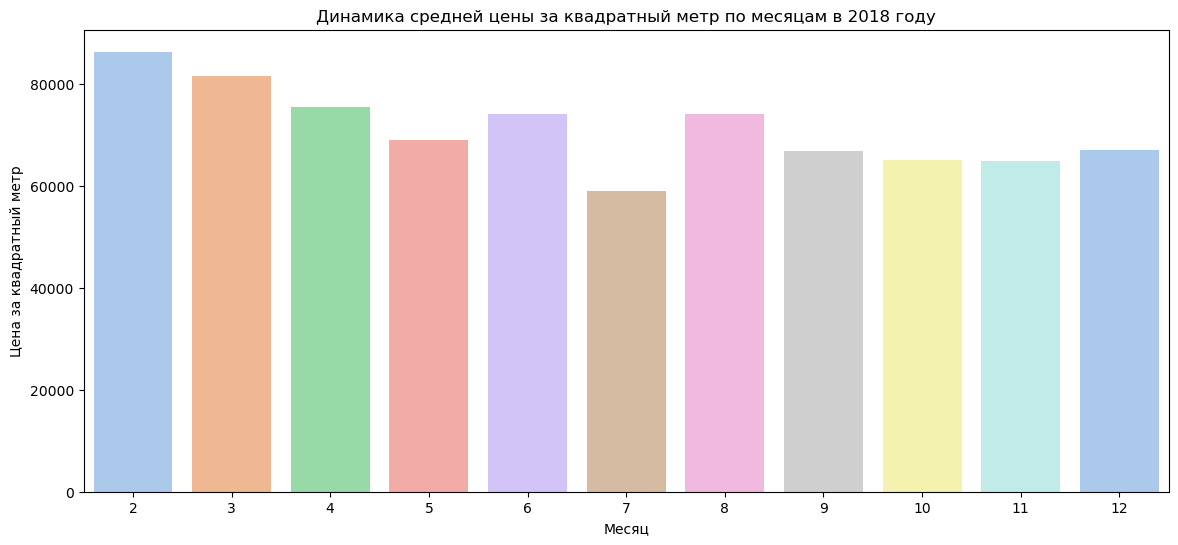

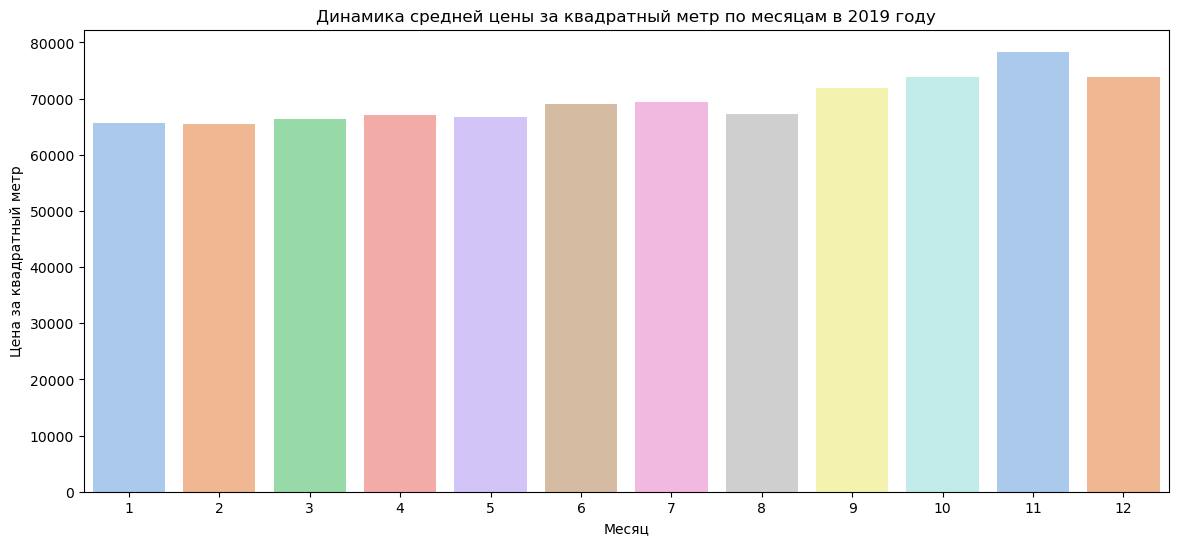

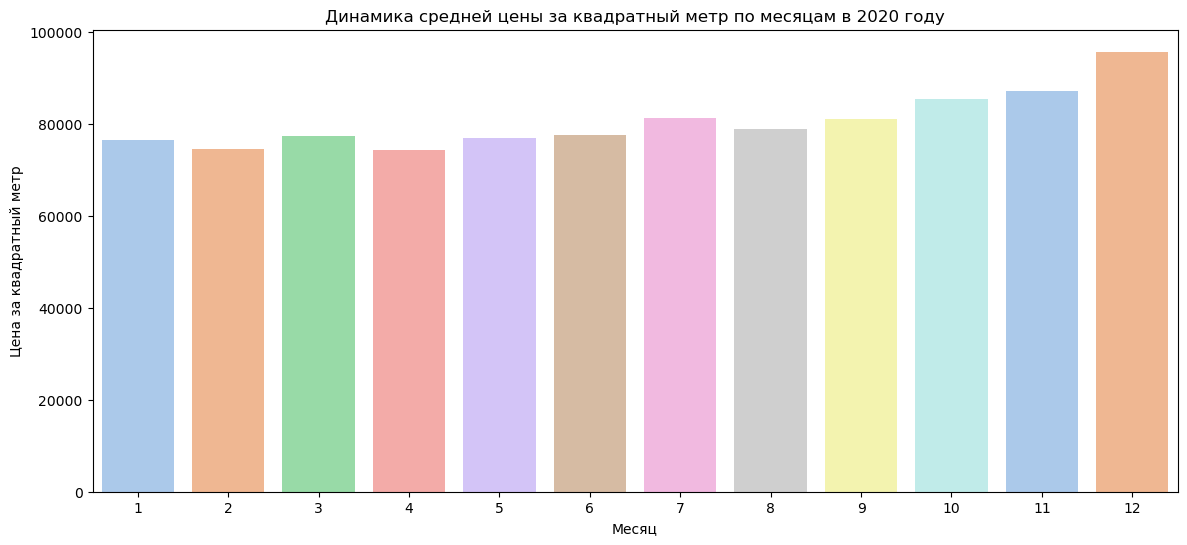

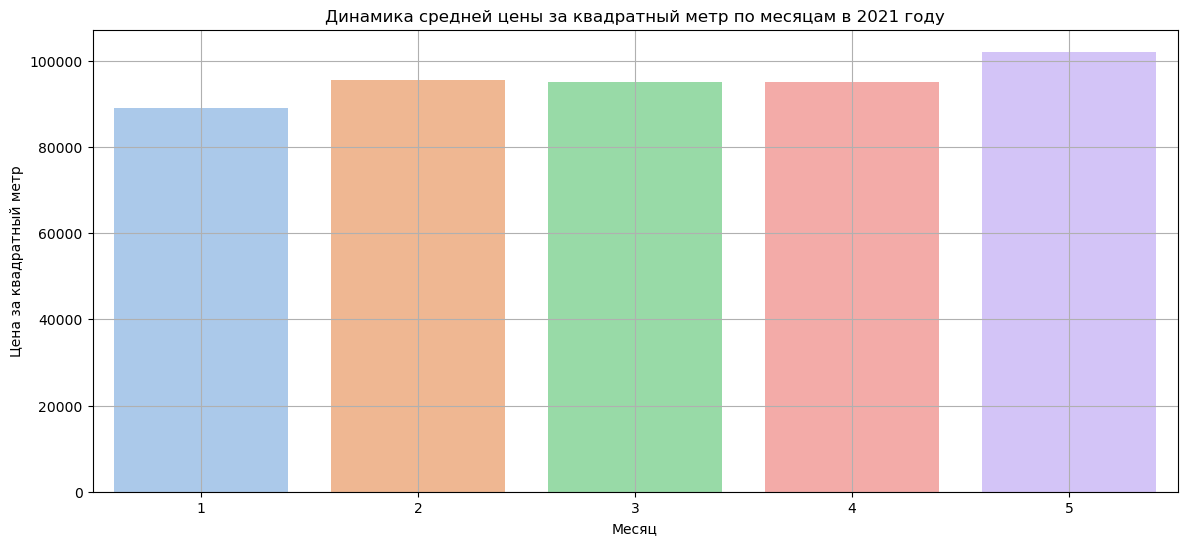

In [701]:
for x in data['year'].unique():
    report = data[data['year'] == x].groupby('month')['price_per_square'].mean().reset_index()
    plt.figure(figsize =(14, 6))
    sns.barplot(report, x = 'month', y = 'price_per_square', palette = 'pastel').set(title = f'Динамика средней цены за квадратный метр по месяцам в {x} году', xlabel = 'Месяц', ylabel = 'Цена за квадратный метр' )
plt.grid()
plt.show()

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

__ВЫВОД__:
    
* В 2018 цена квадратного метра колебалась сильнее всего
* В 2019 - 2021 можно заметить тенденцию роста средней цены квадратного метра с каждым месяцем

In [702]:
def season(month): #функция, которая на вход получает номер месяца и возвращает название сезона
    if month in [1, 2, 12]:
        return 'winter'
    if month in[3, 4, 5]:
        return 'spring'
    if month in[6, 7, 8]:
        return 'summer'
    if month in [9, 10, 11]:
        return 'autumn'
data['season'] = data['month'].apply(season) # Создаем столбец, для записи названия сезона. Применяем к столбцу с номером месяца, функцию для определения сезона

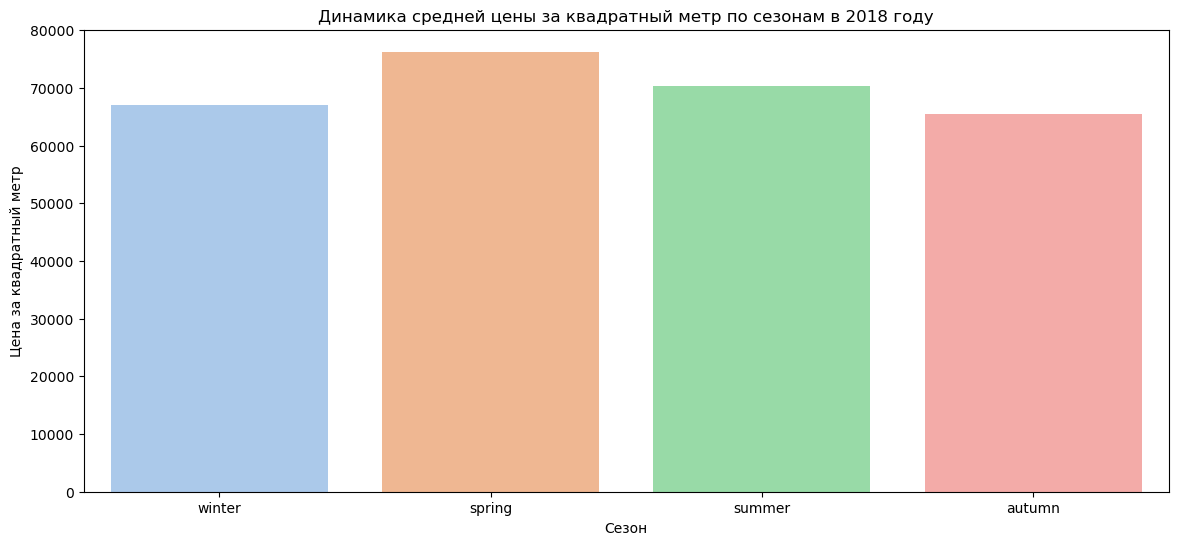

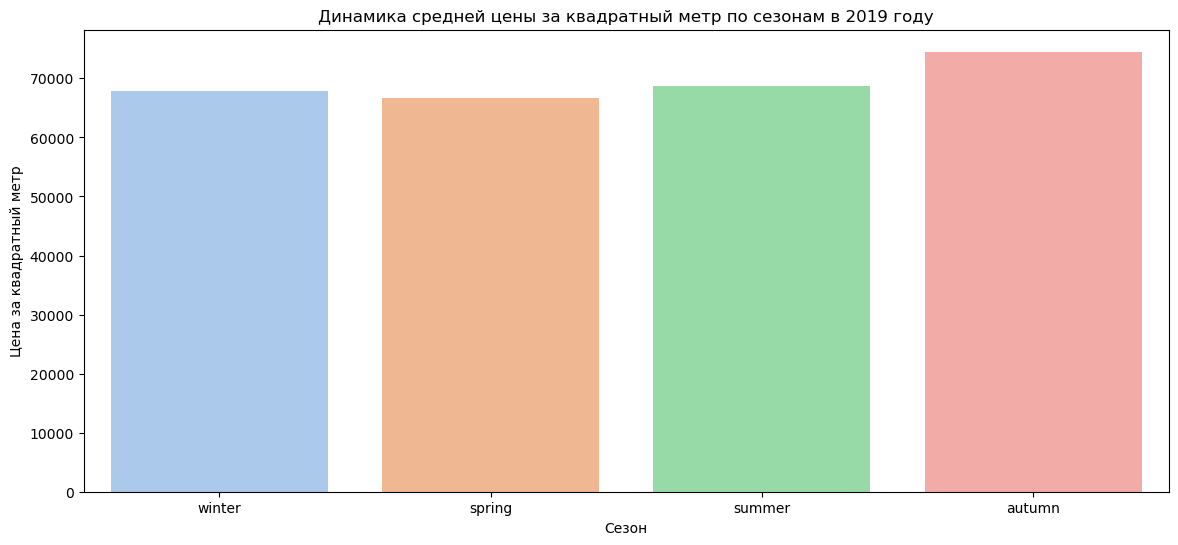

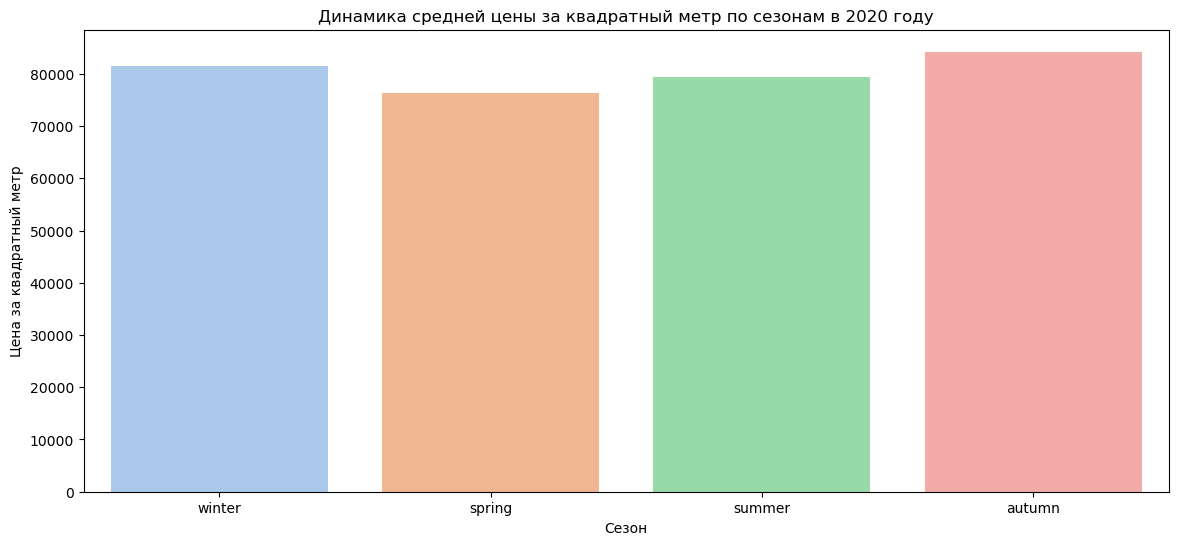

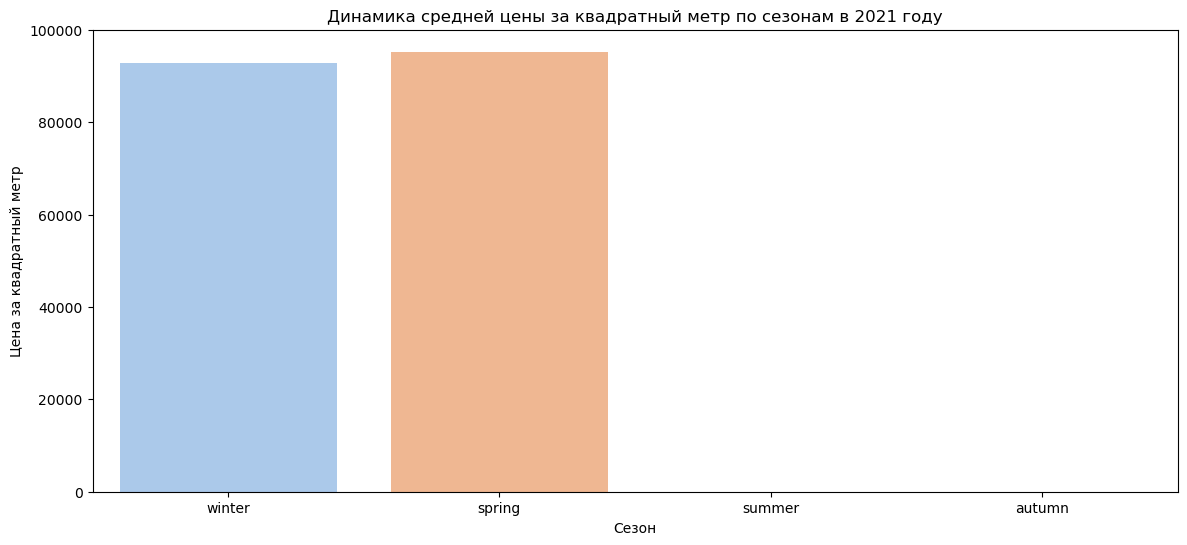

In [703]:
for x in data['year'].unique():
    report =data[data['year'] == x].groupby('season')['price_per_square'].mean()
    report = pd.DataFrame(data = report, index=['winter', 'spring', 'summer', 'autumn'])
    plt.figure(figsize =(14, 6))
    sns.barplot(report, x = report.index, y = 'price_per_square', palette = 'pastel').set(title = f'Динамика средней цены за квадратный метр по сезонам в {x} году', xlabel = 'Сезон', ylabel = 'Цена за квадратный метр' )
plt.show()

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

__ВЫВОД__:
    
* Если сранивать цену на квадратный метр в определенный сезон каждый год, то нет определенной зависимости между ценой и сезоном
* Нельзя сказать, что каждый год в какой-то сезон квартиры дешевле, чем в другой
* Нельзя предсказать когда выгодно покупать/продавать квартиру

[К навигации](#0)

### <a class="anchor" id="6"></a> Определите от каких признаков зависит стоимость объекта недвижимости. Найдите скрытые закономерности.

In [704]:
data['season'] = data['season'].map({'winter':1, 'spring':2, 'summer': 3, 'autumn': 4})

In [705]:
data.head(1)

,price,date,building_type,level,levels,rooms,area,kitchen_area,object_type,reg_name,area_category,price_per_square,year,month,season
0,6050000,2018-02-19,Панельный,8,10,3,82.6,10.8,1,Санкт-Петербург,от 70 до 90 кв метров,73244.55,2018,2,1


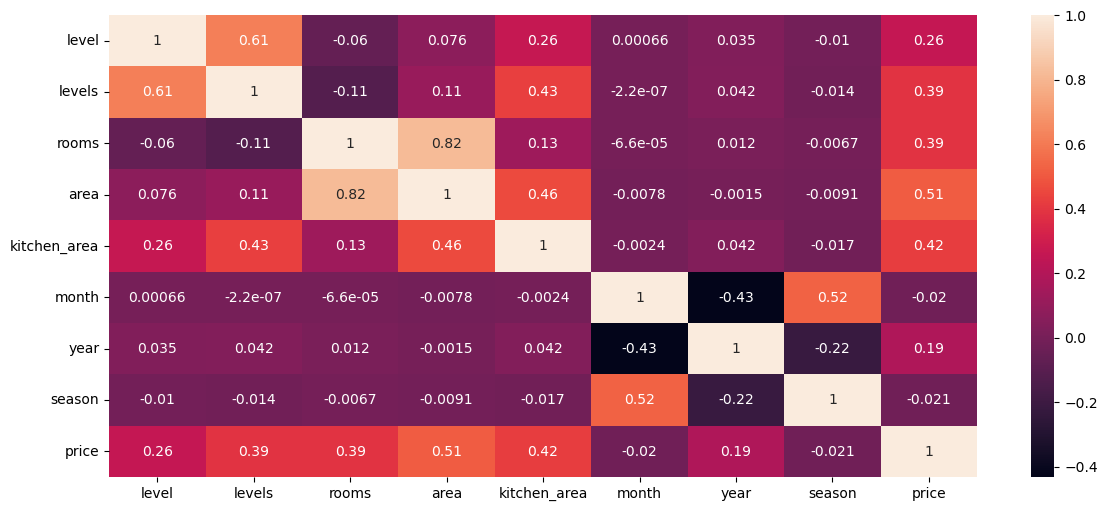

In [706]:
plt.figure(figsize =(14, 6))
sns.heatmap(data[['level', 'levels','rooms', 'area', 'kitchen_area', 'month', 'year', 'season','price']].corr('spearman'), annot= True)
plt.show()

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

__ВЫВОД__:
    
* Прямая умеренная связь есть между ценой и количеством этажей в здании/количеством комнат/площадью кухни
* Прямая заметная связь есть между ценой и площадью недвижимости
* Слабая связь есть между ценой и этажом недвижимости/годом заключения сделки

In [707]:
from scipy import stats
round(stats.pointbiserialr(data['price'], data['object_type'])[0], 1)

-0.1

Есть слабая связь между ценой и рынком на котором продается недвижимость

In [708]:
data = pd.get_dummies(data, columns=['building_type'])
data = data.drop('building_type_другое', axis = 1)
data.head(1)

,price,date,level,levels,rooms,area,kitchen_area,object_type,reg_name,area_category,price_per_square,year,month,season,building_type_Панельный,building_type_блочный,building_type_деревянный,building_type_кирпично-монолитный,building_type_кирпичный
0,6050000,2018-02-19,8,10,3,82.6,10.8,1,Санкт-Петербург,от 70 до 90 кв метров,73244.55,2018,2,1,True,False,False,False,False


In [709]:
stats.pointbiserialr(data['price'], data['building_type_блочный'])[0]

-0.033234849394825336

In [710]:
stats.pointbiserialr(data['price'], data['building_type_деревянный'])[0]

-0.028528983200848013

In [711]:
stats.pointbiserialr(data['price'], data['building_type_кирпично-монолитный'])[0]

0.2860043359973592

In [712]:
stats.pointbiserialr(data['price'], data['building_type_кирпичный'])[0]

-0.09858602524911217

In [713]:
stats.pointbiserialr(data['price'], data['building_type_Панельный'])[0]

-0.15087657900976886

<div style="background-color: #ffe0e5; padding: 10px; border: 1px solid #863FBE;">

__ВЫВОД__:
    
* Сильнее всего на цену влияет Кирпично-монолитное ли здание, если здание из этого материала, то это повышает цену
* Есть слабая связь между ценой и тем панельное ли здание

In [714]:
data['area_category_1'] = data['area_category'].map({'от 10 до 30 кв метров':1, 'от 30 до 50 кв метров':2, 'от 50 до 70 кв метров': 3, 'от 70 до 90 кв метров': 4, 'от 90 до 110 кв метров':5, 'от 110 до 140 кв метров':6})
data.head(1)

,price,date,level,levels,rooms,area,kitchen_area,object_type,reg_name,area_category,price_per_square,year,month,season,building_type_Панельный,building_type_блочный,building_type_деревянный,building_type_кирпично-монолитный,building_type_кирпичный,area_category_1
0,6050000,2018-02-19,8,10,3,82.6,10.8,1,Санкт-Петербург,от 70 до 90 кв метров,73244.55,2018,2,1,True,False,False,False,False,4


In [715]:
data[['area_category_1', 'price']].corr('spearman')

,area_category_1,price
area_category_1,1.000000,0.500832
price,0.500832,1.000000


[К навигации](#0)

### <a class="anchor" id="7"></a> Выдвинете и проверьте собственную гипотезу статистическими методами.

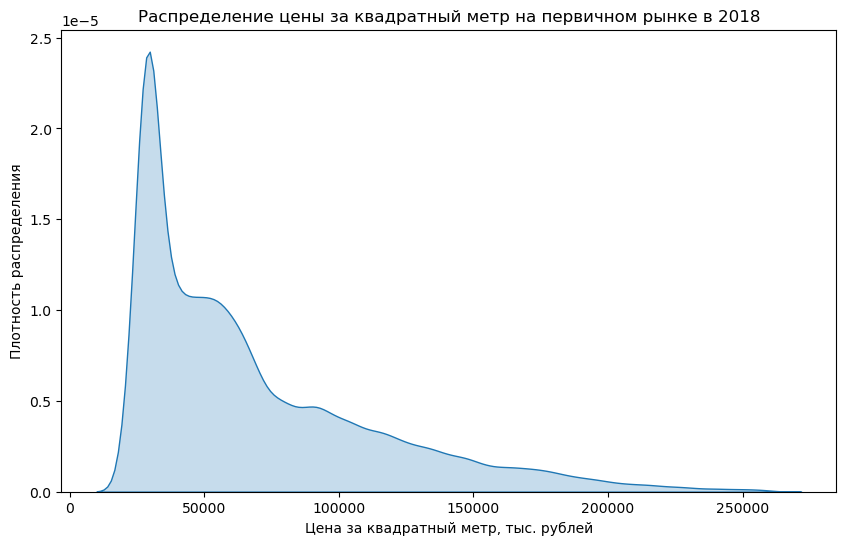

In [716]:
# зададим размер графика
plt.figure(figsize = (10,6))
 
# и построим график функции плотности
sns.kdeplot(data.query('year == 2018 and object_type == 0')['price_per_square'], fill=True)
 
# добавим подписи
plt.xlabel('Цена за квадратный метр, тыс. рублей')
plt.ylabel('Плотность распределения')
plt.title('Распределение цены за квадратный метр на первичном рынке в 2018')
 
plt.show()

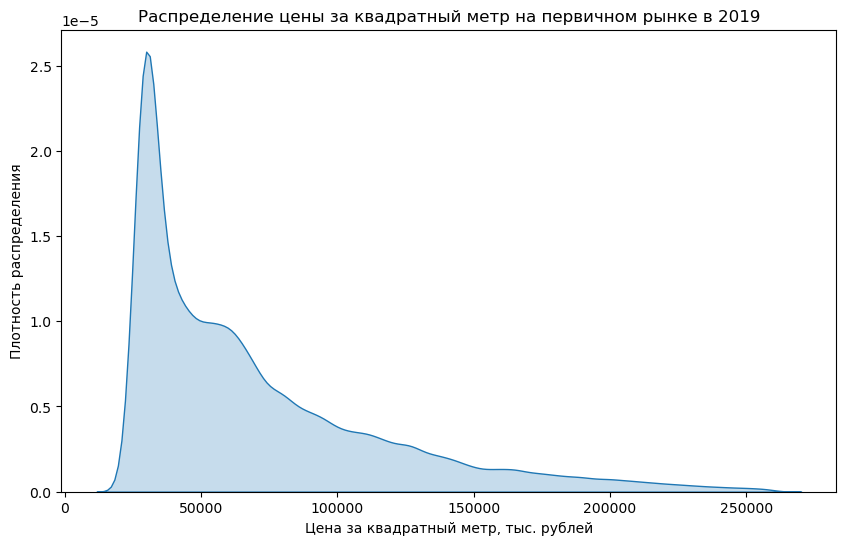

In [717]:
# зададим размер графика
plt.figure(figsize = (10,6))
 
# и построим график функции плотности
sns.kdeplot(data.query('year == 2019 and object_type==0')['price_per_square'], fill=True)
 
# добавим подписи
plt.xlabel('Цена за квадратный метр, тыс. рублей')
plt.ylabel('Плотность распределения')
plt.title('Распределение цены за квадратный метр на первичном рынке в 2019')
 
plt.show()

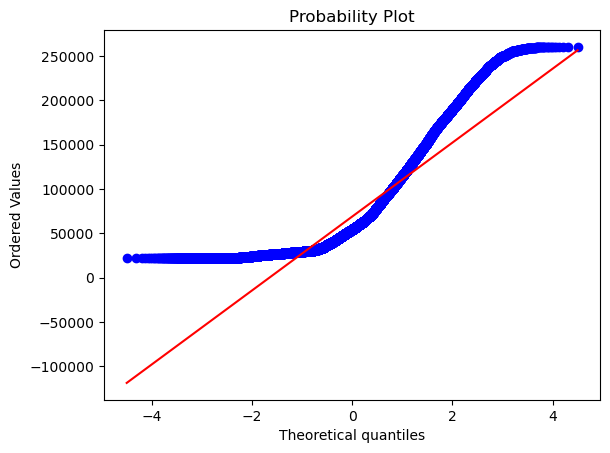

In [718]:
price_2018 = data.query('year == 2018 and object_type == 0 ')['price_per_square'].to_list()
price_2019 = data.query(' year == 2019 and object_type == 0')['price_per_square'].to_list()
st.probplot((price_2018), dist = norm, plot = plt)
plt.show()

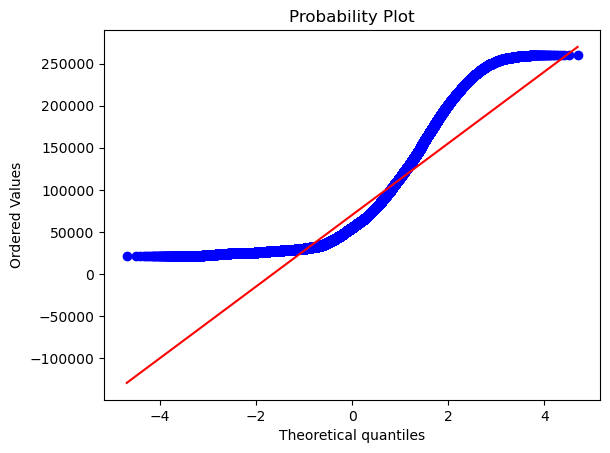

In [719]:
st.probplot(price_2019, dist = norm, plot = plt)
plt.show()

Видно, что цена за квадратный метр на первичном рынке в 2018 и 2019 не имеет нормального распределения

Значит для проверки гипотезы нам следует использовать непараметрический тест Уилкоксона-Манна-Уитни

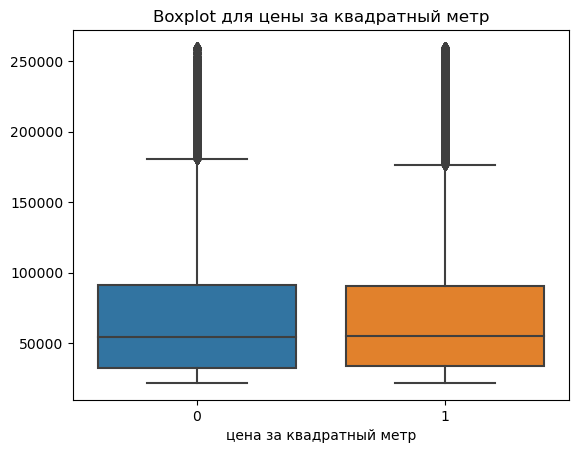

In [720]:
sns.boxplot(data = [price_2018, price_2019 ])
plt.title('Boxplot для цены за квадратный метр')
plt.xlabel('цена за квадратный метр')
plt.show()

__H0:Средняя цена квадратного метра на первичном рынке в 2018 и 2019 не различается__

__H1:Средняя цена квадратного метра на первичном рынке в 2018 и 2019 различается__

In [721]:
#H0 Выручка для групп не отличается
alpha = 0.05 # Уровень значимости
results = st.mannwhitneyu(price_2018, price_2019)
print('p-value:', results.pvalue)
if results.pvalue < alpha:
    print('Следует отвергнуть нулевую гипотезу, цена квадратного метра для двух групп различается') 
else:
    print('Не удалось отвергнуть нулевую гипотезу, цена квадратного метра для двух групп не различается') 

p-value: 1.9055931661228766e-66
Следует отвергнуть нулевую гипотезу, цена квадратного метра для двух групп различается


[К навигации](#0)

### <a class="anchor" id="8"></a> Создайте модель прогноза цены объекта недвижимости.

In [742]:
y = data['price']
x = data[['level','levels', 'area','kitchen_area', 'year','month', 'building_type_кирпичный','building_type_деревянный','building_type_блочный', 'building_type_кирпично-монолитный','building_type_Панельный', 'reg_name', 'object_type']]

In [743]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 100)

In [744]:
from category_encoders import TargetEncoder
encoder = TargetEncoder(smoothing=0.1)
x_train['reg_name'] = encoder.fit_transform(x_train['reg_name'] , np.log(y_train))#При кодировании региона каждое его значение будем заменять на среднее значение целевой переменной для всех объектов с такой категорией.

In [745]:
scaler = StandardScaler()
x_train_st = scaler.fit_transform(x_train)

In [746]:
model = Ridge()
model.fit(x_train_st, np.log(y_train))

print(model.coef_, model.intercept_)

[ 0.00567524  0.10088612  0.28637472  0.03469086  0.09869898  0.03077288
 -0.02465263 -0.01635641 -0.02214528 -0.00106936 -0.05884405  0.35101997
  0.07098351] 14.991933609665242


In [747]:
x_test['reg_name'] = encoder.fit_transform(x_test['reg_name'] , np.log(y_test))#При кодировании региона каждое его значение будем заменять на среднее значение целевой переменной для всех объектов с такой категорией.
x_test_st = scaler.fit_transform(x_test)

In [748]:
predictions = np.exp(model.predict(x_test_st))


In [749]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
round(r2_score(y_test, predictions), 2)

0.76

C:\Users\paula\AppData\Local\Temp\ipykernel_5824\3260566455.py:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 2, 1)
C:\Users\paula\AppData\Local\Temp\ipykernel_5824\3260566455.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],  "k--", color='r')


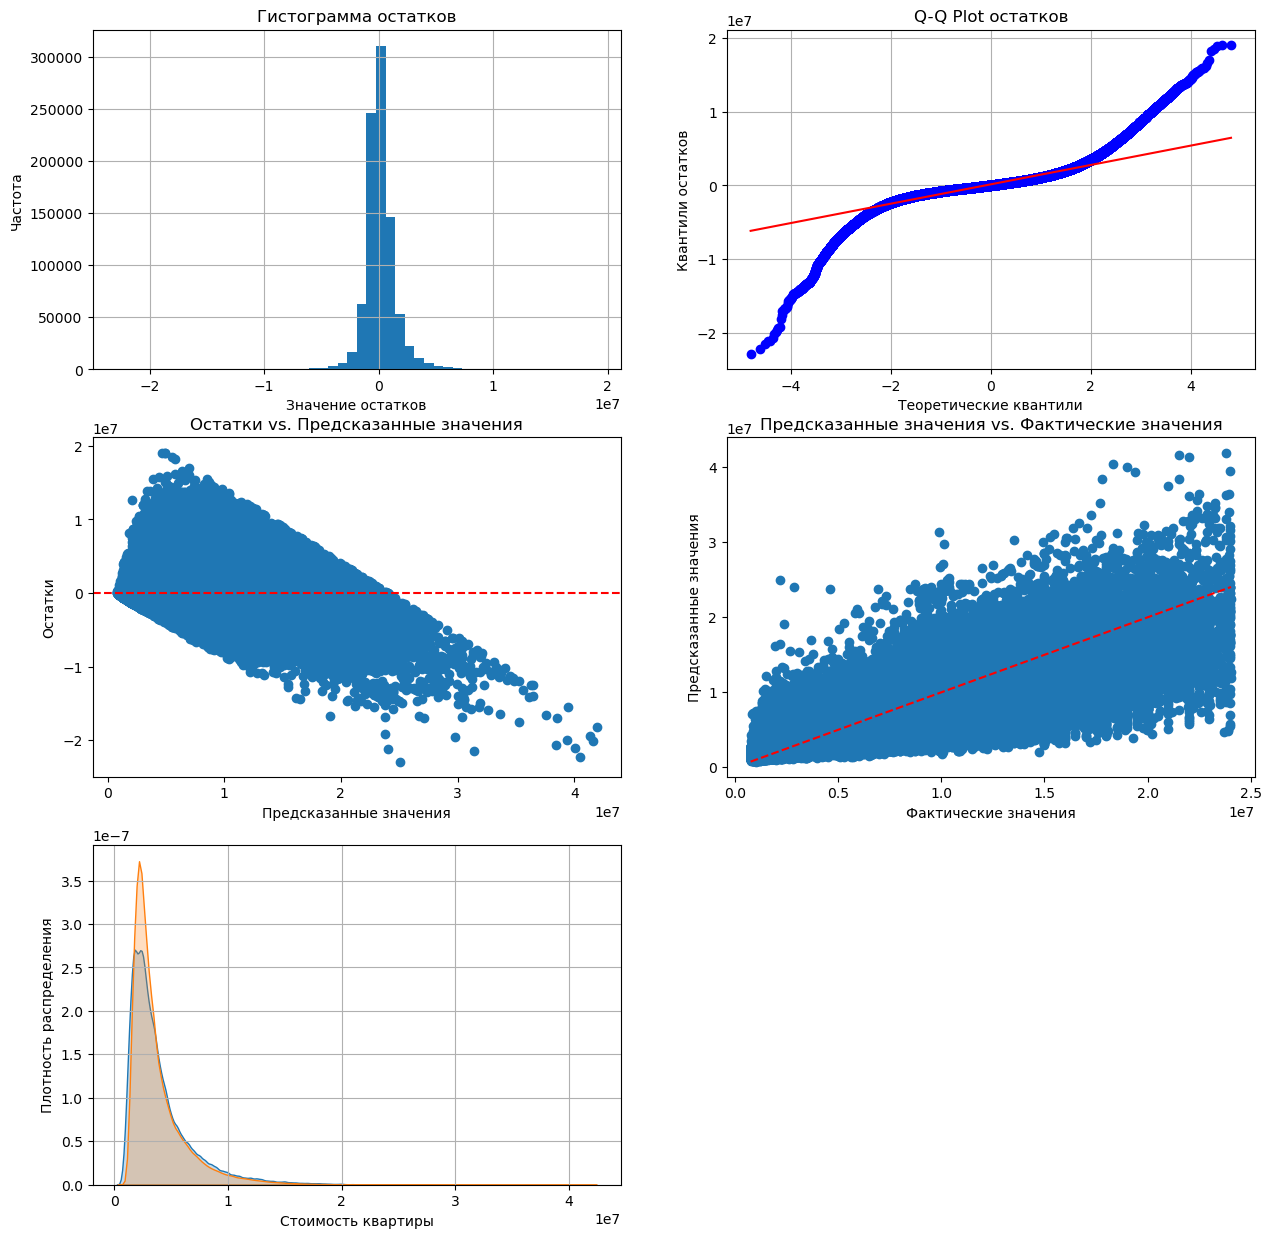

In [750]:
import statsmodels.api as sm

# Получение остатков модели
residuals = y_test - predictions

# Расчет стандартизированных остатков
stand_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
plt.subplots(figsize=(15, 15))


# Распределение остатков
plt.subplot(3, 2, 1)
plt.hist(residuals, bins = 50)
plt.xlabel('Значение остатков')
plt.ylabel('Частота')
plt.title('Гистограмма остатков')
plt.grid(True)


# График остатков vs. предсказанных значений
plt.subplot(3, 2, 2)
st.probplot(residuals, dist='norm', plot=plt)
plt.xlabel('Теоретические квантили')
plt.ylabel('Квантили остатков')
plt.title('Q-Q Plot остатков')
plt.grid(True)

#График остатков относительно прогноза
plt.subplot(3, 2, 3)
plt.scatter(predictions, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказанные значения')
plt.ylabel('Остатки')
plt.title('Остатки vs. Предсказанные значения')

# Предсказанные и фактические значения
plt.subplot(3, 2, 4)
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],  "k--", color='r')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные значения vs. Фактические значения')

plt.subplot(3, 2, 5)
sns.kdeplot(y_test, fill = True)
sns.kdeplot(predictions, fill = True)
plt.xlabel('Стоимость квартиры')
plt.ylabel('Плотность распределения')
plt.grid(True)